# Analisis Dataset COMPAS (Correctional Offender Management Profiling for Alternative Sanctions)

Notebook ini berisi analisis lengkap dataset COMPAS yang mencakup:
1. Feature Engineering, EDA, dan Data Visualization pada setiap fitur
2. Pemodelan dan evaluasi menggunakan matriks evaluasi (Akurasi, Presisi, Recall, F1-Score, AUC, ROC)
3. Penjelasan detail untuk setiap persamaan matematika yang digunakan

Dataset COMPAS digunakan untuk memprediksi risiko residivisme (kemungkinan mengulangi tindak kriminal) dan merupakan dataset penting dalam diskusi tentang bias algoritma dalam sistem peradilan.

In [24]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import scipy.stats as stats
import warnings

# Mengabaikan warning
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('viridis', 10)
sns.set_palette(colors)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Membaca dan Eksplorasi Data Awal

Dataset COMPAS berisi data tentang terdakwa di pengadilan yang dinilai tingkat risiko residivismenya. Variabel target utama adalah `two_year_recid` yang menunjukkan apakah terdakwa melakukan kejahatan lagi dalam dua tahun.

In [25]:
# Membaca dataset COMPAS
df = pd.read_csv('compas-scores-two-years.csv')

# Tampilkan 5 data pertama
print("== LIMA DATA PERTAMA ==\n")
df.head()

== LIMA DATA PERTAMA ==



,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [26]:
# Informasi tentang dataset
print(f"Jumlah baris dan kolom: {df.shape}\n")
df.info()

Jumlah baris dan kolom: (7214, 53)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   i

In [27]:
# Memeriksa nilai yang hilang
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Jumlah nilai hilang': missing_values,
    'Persentase (%)': missing_percent
})

# Menampilkan hanya kolom dengan nilai yang hilang
missing_summary = missing_df[missing_df['Jumlah nilai hilang'] > 0].sort_values('Persentase (%)', ascending=False)

if not missing_summary.empty:
    print("Kolom dengan nilai yang hilang:")
    print(missing_summary)
else:
    print("Tidak ada nilai yang hilang dalam dataset!")

Kolom dengan nilai yang hilang:
                         Jumlah nilai hilang  Persentase (%)
violent_recid                           7214      100.000000
vr_offense_date                         6395       88.647075
vr_charge_degree                        6395       88.647075
vr_case_number                          6395       88.647075
vr_charge_desc                          6395       88.647075
c_arrest_date                           6077       84.238980
r_jail_out                              4898       67.895758
r_jail_in                               4898       67.895758
r_days_from_arrest                      4898       67.895758
r_charge_desc                           3801       52.689215
r_offense_date                          3743       51.885223
r_charge_degree                         3743       51.885223
r_case_number                           3743       51.885223
c_offense_date                          1159       16.065983
days_b_screening_arrest                  307        4

In [28]:
# Statistik deskriptif untuk kolom numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7214.0,5501.255753,3175.706870,1.0,2735.25,5509.5,8246.5,11001.0
age,7214.0,34.817993,11.888922,18.0,25.00,31.0,42.0,96.0
juv_fel_count,7214.0,0.067230,0.473972,0.0,0.00,0.0,0.0,20.0
decile_score,7214.0,4.509565,2.856396,1.0,2.00,4.0,7.0,10.0
juv_misd_count,7214.0,0.090934,0.485239,0.0,0.00,0.0,0.0,13.0
juv_other_count,7214.0,0.109371,0.501586,0.0,0.00,0.0,0.0,17.0
priors_count,7214.0,3.472415,4.882538,0.0,0.00,2.0,5.0,38.0
days_b_screening_arrest,6907.0,3.304763,75.809505,-414.0,-1.00,-1.0,0.0,1057.0
c_days_from_compas,7192.0,57.731368,329.740215,0.0,1.00,1.0,2.0,9485.0
is_recid,7214.0,0.481148,0.499679,0.0,0.00,0.0,1.0,1.0


Distribusi variabel target (two_year_recid):
                Jumlah  Persentase (%)
two_year_recid                        
0                 3963       54.934849
1                 3251       45.065151


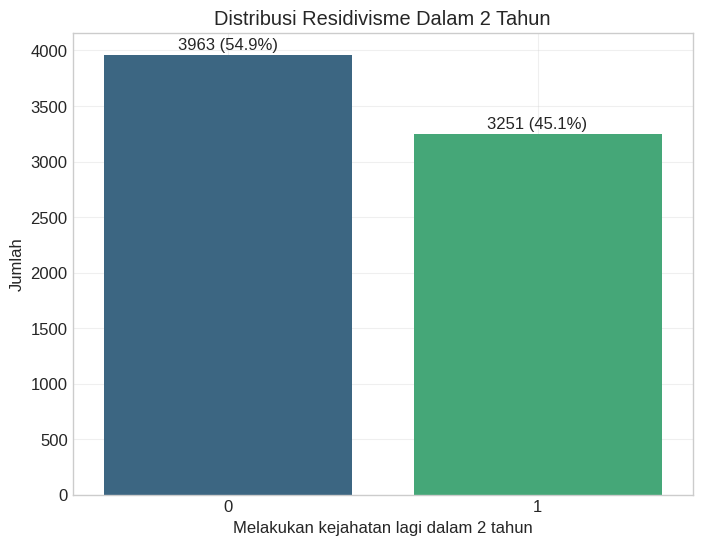

In [29]:
# Memeriksa variabel target (two_year_recid)
if 'two_year_recid' in df.columns:
    print("Distribusi variabel target (two_year_recid):")
    target_counts = df['two_year_recid'].value_counts()
    target_percent = df['two_year_recid'].value_counts(normalize=True) * 100

    target_distribution = pd.DataFrame({
        'Jumlah': target_counts,
        'Persentase (%)': target_percent
    })

    print(target_distribution)

    # Visualisasi distribusi target
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x='two_year_recid', data=df, palette='viridis')
    plt.title('Distribusi Residivisme Dalam 2 Tahun')
    plt.xlabel('Melakukan kejahatan lagi dalam 2 tahun')
    plt.ylabel('Jumlah')

    # Menambahkan label nilai di atas bar
    for i, v in enumerate(target_counts):
        ax.text(i, v + 50, f"{v} ({target_percent[i]:.1f}%)", ha='center')

    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Variabel target 'two_year_recid' tidak ditemukan dalam dataset.")
    print("Kolom yang tersedia:", df.columns.tolist())

## 2. Menentukan dan Memproses Variabel Target

Jika 'two_year_recid' tidak ada, kita perlu menentukan variabel target berdasarkan kolom yang tersedia.
Dalam dataset COMPAS, biasanya 'is_recid' atau 'is_violent_recid' dapat digunakan sebagai target alternatif.

In [30]:
# Memeriksa kolom potensial untuk variabel target
target_candidates = ['two_year_recid', 'is_recid', 'is_violent_recid', 'decile_score']
available_targets = [col for col in target_candidates if col in df.columns]

if available_targets:
    print("Kolom yang dapat digunakan sebagai variabel target:")
    for col in available_targets:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        percent = df[col].value_counts(normalize=True) * 100

        distribution = pd.DataFrame({
            'Jumlah': value_counts,
            'Persentase (%)': percent
        })

        print(distribution)
else:
    print("Tidak ada kolom target standar yang tersedia. Mencari alternatif...")
    # Periksa kolom dengan nilai biner (0/1)
    binary_cols = []
    for col in df.columns:
        if set(df[col].dropna().unique()).issubset({0, 1}):
            binary_cols.append(col)

    if binary_cols:
        print("\nKolom dengan nilai biner yang dapat digunakan sebagai target:")
        print(binary_cols)
    else:
        print("Tidak ada kolom biner yang dapat digunakan sebagai target.")

Kolom yang dapat digunakan sebagai variabel target:

two_year_recid:
                Jumlah  Persentase (%)
two_year_recid                        
0                 3963       54.934849
1                 3251       45.065151

is_recid:
          Jumlah  Persentase (%)
is_recid                        
0           3743       51.885223
1           3471       48.114777

is_violent_recid:
                  Jumlah  Persentase (%)
is_violent_recid                        
0                   6395       88.647075
1                    819       11.352925

decile_score:
              Jumlah  Persentase (%)
decile_score                        
1               1440       19.961187
2                941       13.044081
4                769       10.659828
3                747       10.354866
5                681        9.439978
6                641        8.885500
7                592        8.206266
8                512        7.097311
9                508        7.041863
10               383       

In [31]:
# Menentukan variabel target
if 'two_year_recid' in df.columns:
    target_col = 'two_year_recid'
elif 'is_recid' in df.columns:
    target_col = 'is_recid'
elif len(binary_cols) > 0 if 'binary_cols' in locals() else False:
    target_col = binary_cols[0]
else:
    # Jika tidak ada target biner, gunakan `decile_score` dan ubah menjadi biner
    if 'decile_score' in df.columns:
        target_col = 'decile_score'
        # Konversi ke biner: >= 5 dianggap berisiko tinggi
        df['is_high_risk'] = (df['decile_score'] >= 5).astype(int)
        target_col = 'is_high_risk'
        print(f"Membuat variabel target 'is_high_risk' berdasarkan decile_score >= 5")
    else:
        raise ValueError("Tidak dapat menentukan variabel target yang sesuai")

print(f"\nMenggunakan '{target_col}' sebagai variabel target.")


Menggunakan 'two_year_recid' sebagai variabel target.


## 3. Data Exploration dan Visualisasi

Kita akan mengeksplorasi hubungan antara variabel target dan fitur-fitur lain dalam dataset.

In [32]:
# Mengidentifikasi kolom kategorik dan numerik
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Hapus kolom ID dan kolom target dari list fitur
exclude_cols = ['id', 'name', 'first', 'last', target_col]
categorical_cols = [col for col in categorical_cols if col not in exclude_cols]
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Kolom kategorik ({len(categorical_cols)}): {categorical_cols[:5]}...")
print(f"Kolom numerik ({len(numeric_cols)}): {numeric_cols[:5]}...")

Kolom kategorik (30): ['compas_screening_date', 'sex', 'dob', 'age_cat', 'race']...
Kolom numerik (18): ['age', 'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count']...


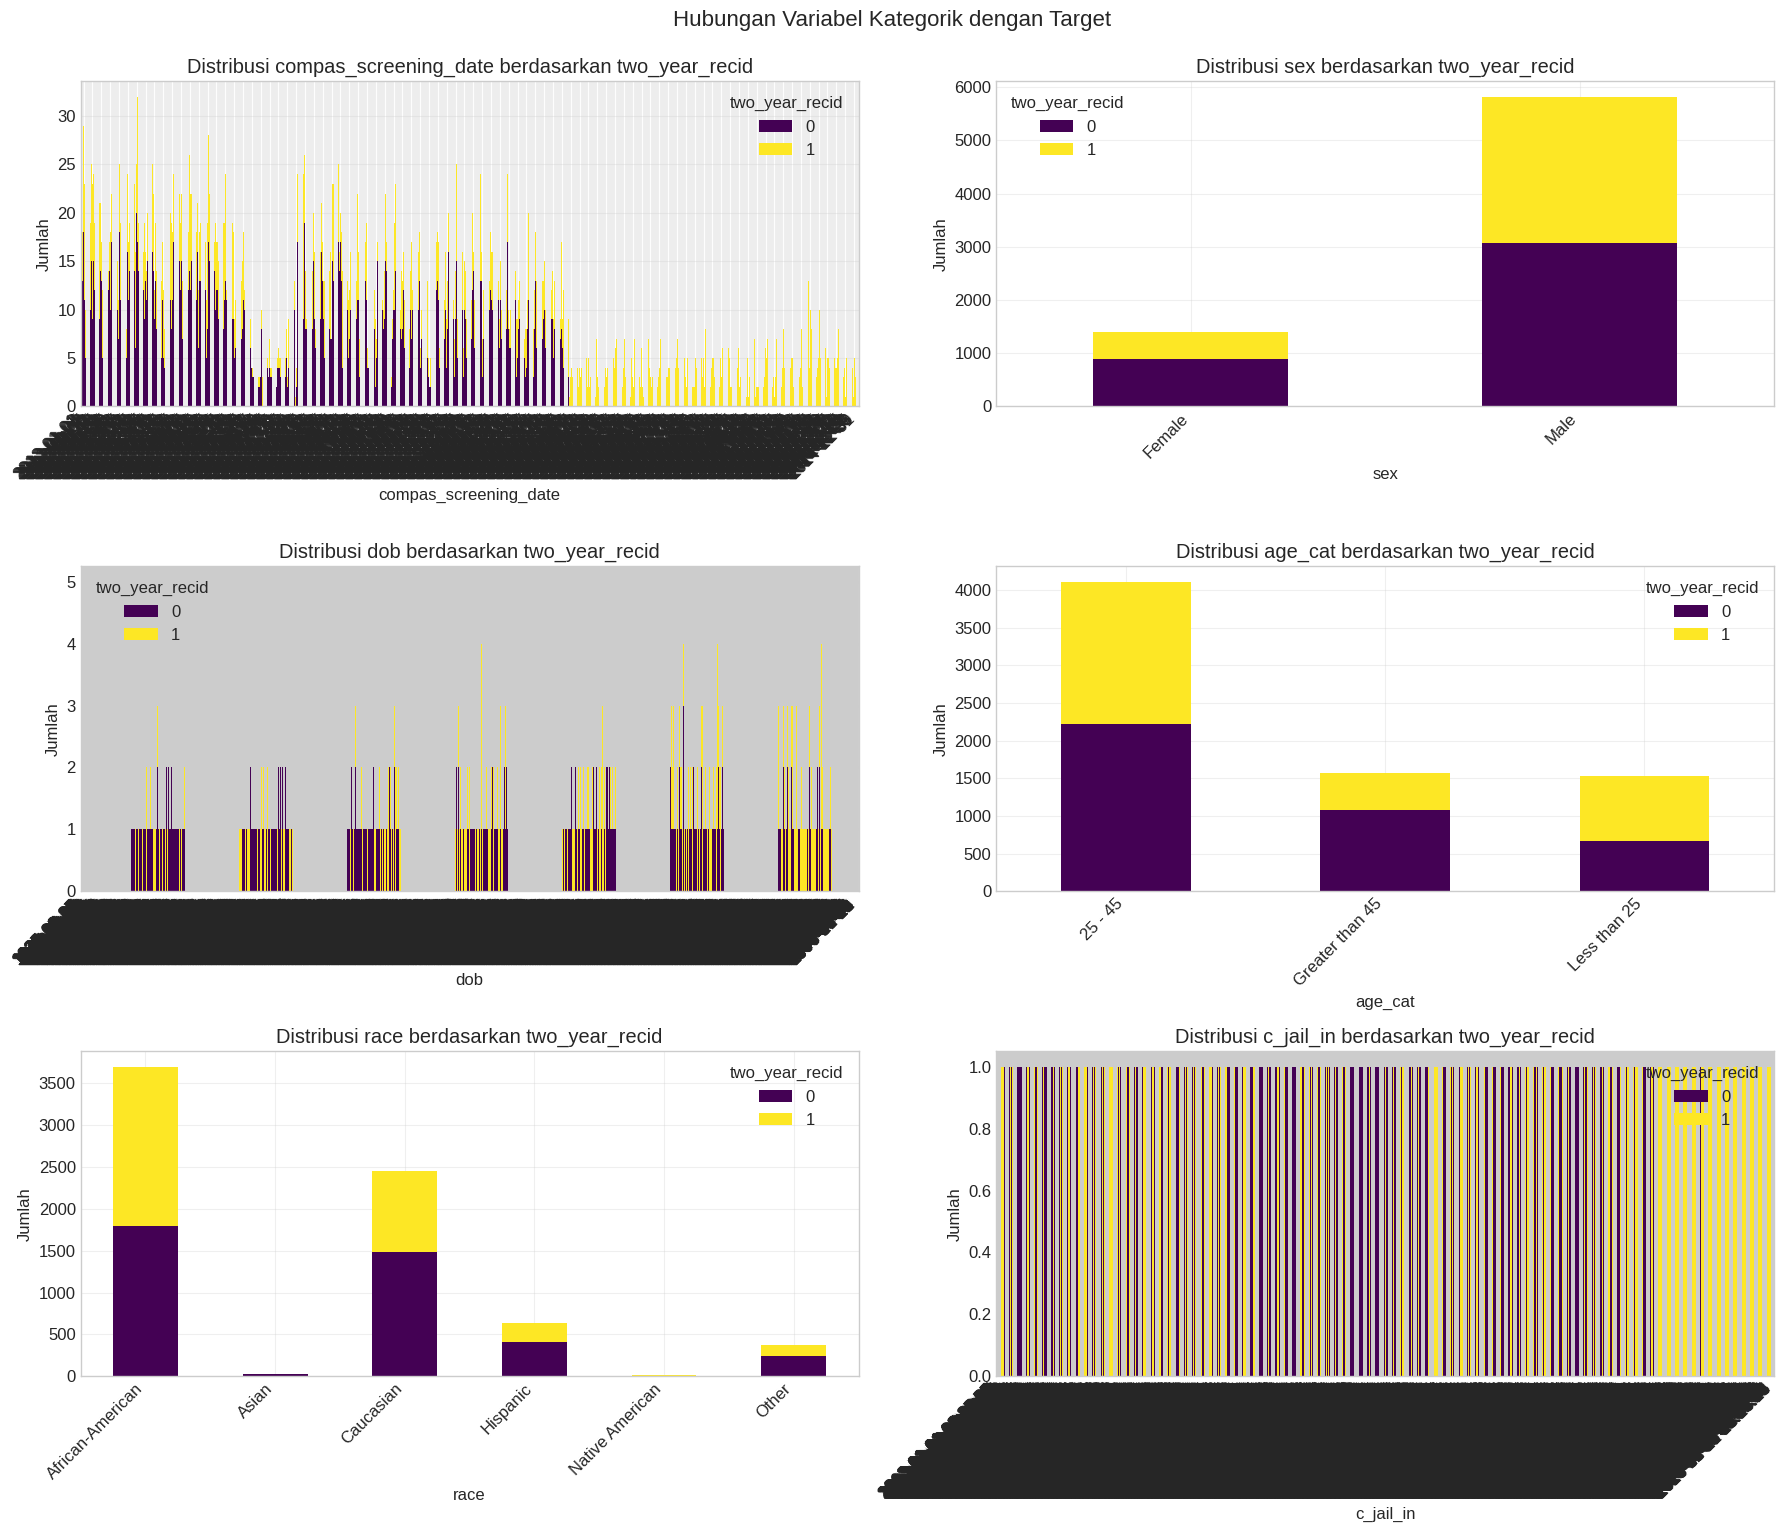


Persentase two_year_recid=1 untuk setiap nilai compas_screening_date:
2014-12-13: 100.0%
2014-12-31: 100.0%
2014-12-12: 100.0%
2014-12-11: 100.0%
2014-12-10: 100.0%
2014-12-09: 100.0%
2014-04-02: 100.0%
2014-04-03: 100.0%
2014-04-04: 100.0%
2014-04-05: 100.0%
2014-04-06: 100.0%
2014-04-07: 100.0%
2014-04-08: 100.0%
2014-04-09: 100.0%
2014-04-10: 100.0%
2014-04-11: 100.0%
2014-04-12: 100.0%
2014-11-05: 100.0%
2014-11-06: 100.0%
2014-11-07: 100.0%
2014-11-09: 100.0%
2014-11-10: 100.0%
2014-11-11: 100.0%
2014-11-12: 100.0%
2014-11-13: 100.0%
2014-11-14: 100.0%
2014-11-15: 100.0%
2014-11-16: 100.0%
2014-11-17: 100.0%
2014-11-18: 100.0%
2014-11-19: 100.0%
2014-11-20: 100.0%
2014-11-21: 100.0%
2014-10-22: 100.0%
2014-10-23: 100.0%
2014-10-24: 100.0%
2014-10-25: 100.0%
2014-10-26: 100.0%
2014-10-27: 100.0%
2014-10-28: 100.0%
2014-10-29: 100.0%
2014-10-30: 100.0%
2014-10-31: 100.0%
2014-11-01: 100.0%
2014-11-02: 100.0%
2014-11-03: 100.0%
2014-11-04: 100.0%
2014-10-06: 100.0%
2014-10-07: 100.0

In [33]:
# Eksplorasi variabel kategorik dan hubungannya dengan target
# Pilih 6 variabel kategorik penting untuk visualisasi
important_cat_cols = categorical_cols[:6] if len(categorical_cols) >= 6 else categorical_cols

plt.figure(figsize=(18, 15))
for i, col in enumerate(important_cat_cols):
    plt.subplot(3, 2, i+1)
    crosstab = pd.crosstab(df[col], df[target_col])
    crosstab_pct = pd.crosstab(df[col], df[target_col], normalize='index') * 100

    crosstab.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
    plt.title(f'Distribusi {col} berdasarkan {target_col}')
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title=target_col)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Hubungan Variabel Kategorik dengan Target', fontsize=16, y=1.02)
plt.show()

# Menampilkan persentase target=1 untuk setiap kategori
for col in important_cat_cols:
    crosstab_pct = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    if 1 in crosstab_pct.columns:
        print(f"\nPersentase {target_col}=1 untuk setiap nilai {col}:")
        sorted_pct = crosstab_pct[1].sort_values(ascending=False)
        for cat, pct in sorted_pct.items():
            print(f"{cat}: {pct:.1f}%")

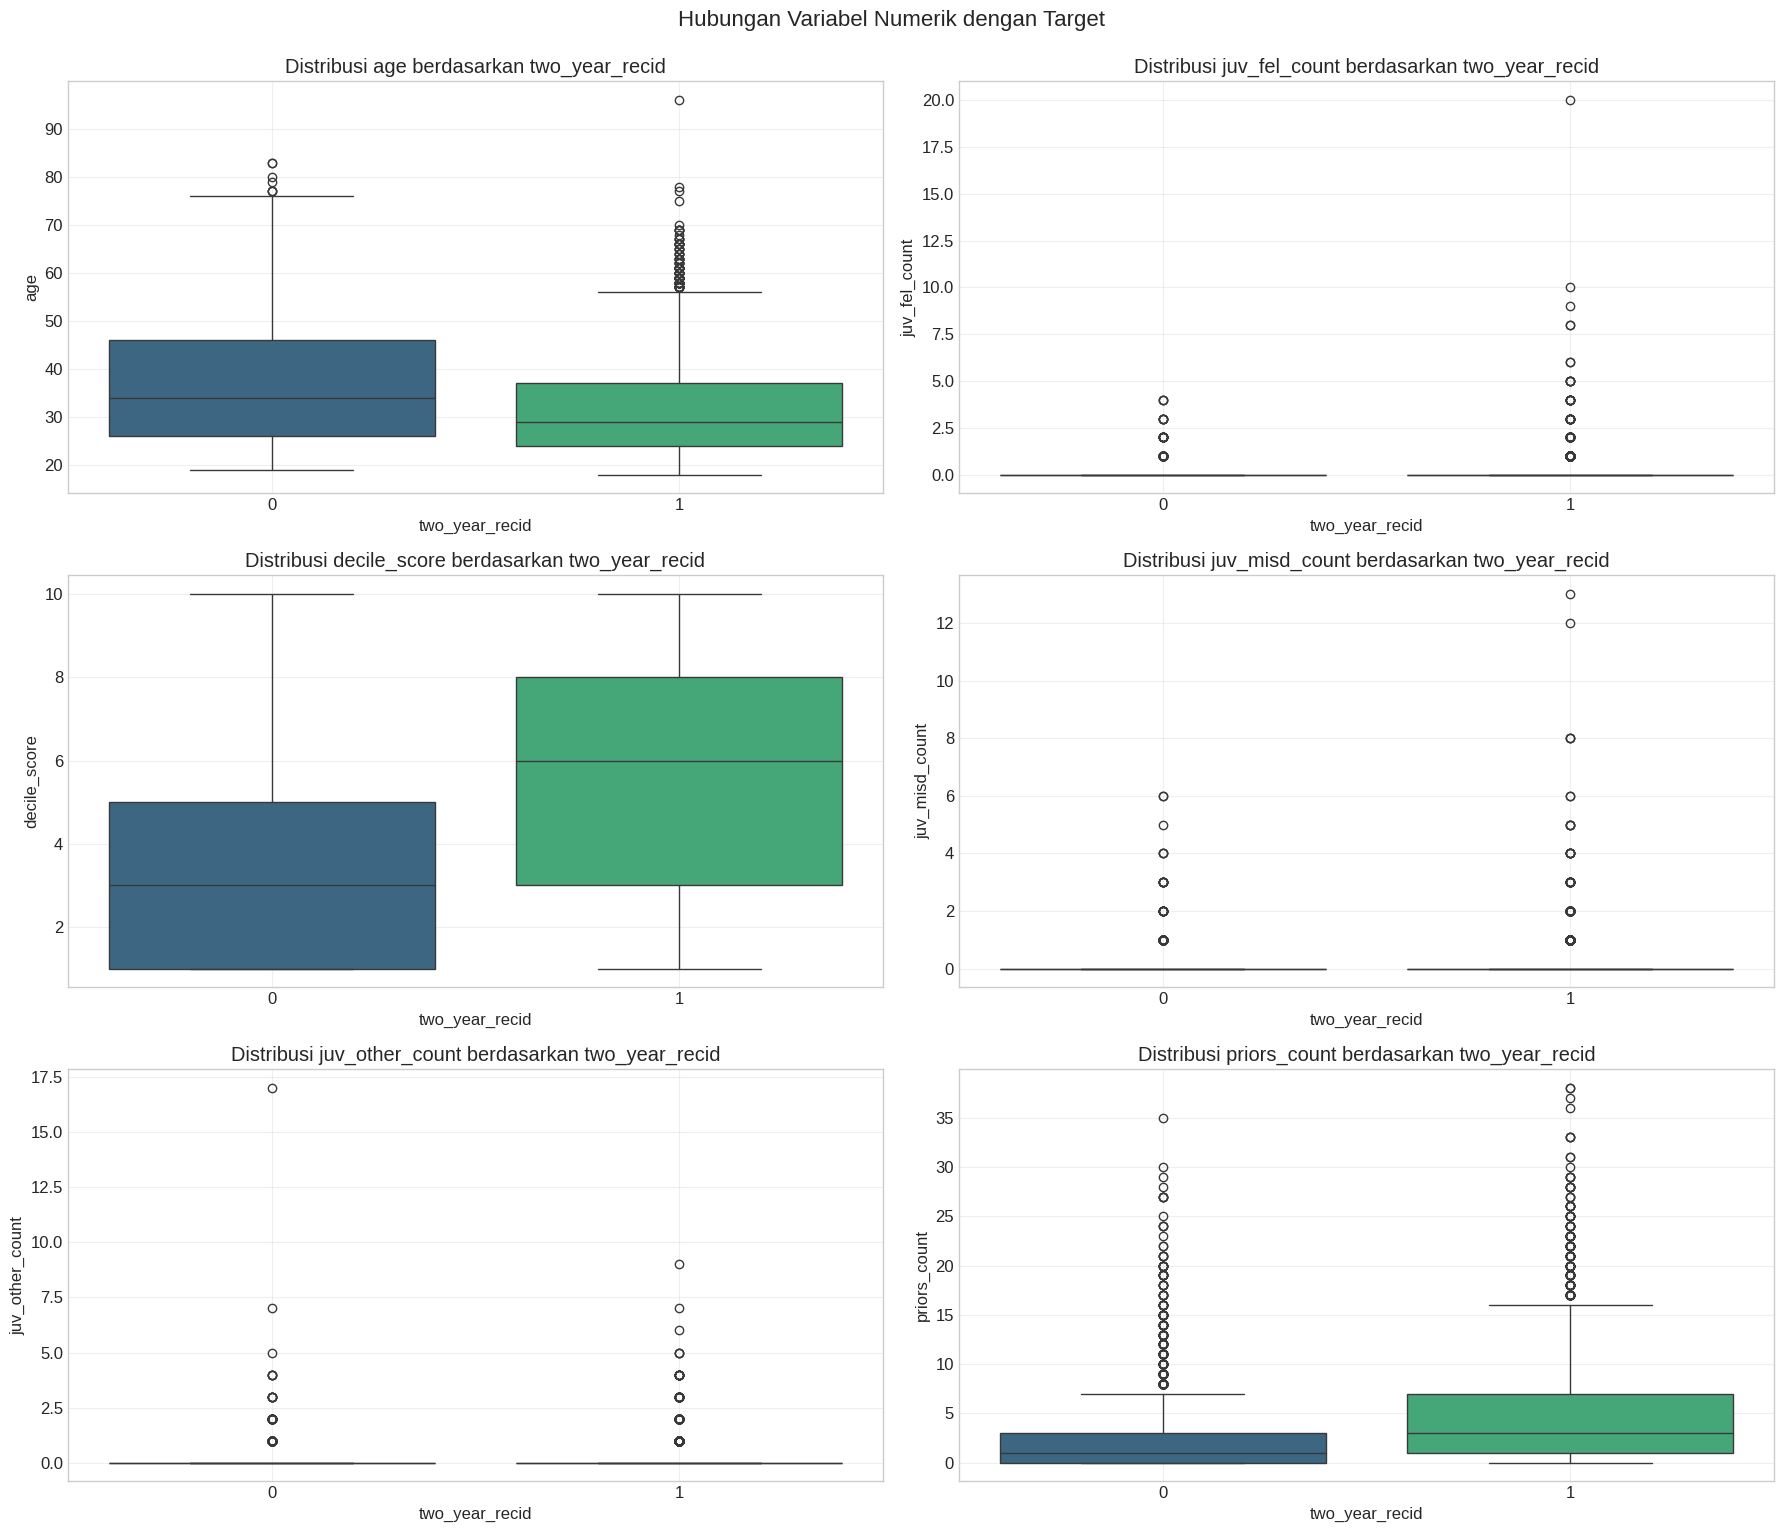


Statistik age berdasarkan two_year_recid:
                 mean  median    std
two_year_recid                      
0               36.87    34.0  12.40
1               32.32    29.0  10.72

Statistik juv_fel_count berdasarkan two_year_recid:
                mean  median   std
two_year_recid                    
0               0.03     0.0  0.23
1               0.12     0.0  0.66

Statistik decile_score berdasarkan two_year_recid:
                mean  median   std
two_year_recid                    
0               3.60     3.0  2.55
1               5.62     6.0  2.82

Statistik juv_misd_count berdasarkan two_year_recid:
                mean  median   std
two_year_recid                    
0               0.04     0.0  0.30
1               0.15     0.0  0.64

Statistik juv_other_count berdasarkan two_year_recid:
                mean  median   std
two_year_recid                    
0               0.06     0.0  0.43
1               0.17     0.0  0.58

Statistik priors_count berdasarkan

In [34]:
# Eksplorasi variabel numerik dan hubungannya dengan target
# Pilih 6 variabel numerik penting untuk visualisasi
important_num_cols = numeric_cols[:6] if len(numeric_cols) >= 6 else numeric_cols

plt.figure(figsize=(18, 15))
for i, col in enumerate(important_num_cols):
    plt.subplot(3, 2, i+1)
    sns.boxplot(x=target_col, y=col, data=df, palette='viridis')
    plt.title(f'Distribusi {col} berdasarkan {target_col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Hubungan Variabel Numerik dengan Target', fontsize=16, y=1.02)
plt.show()

# Menampilkan statistik untuk setiap variabel numerik berdasarkan target
for col in important_num_cols:
    print(f"\nStatistik {col} berdasarkan {target_col}:")
    stats_by_target = df.groupby(target_col)[col].agg(['mean', 'median', 'std']).round(2)
    print(stats_by_target)

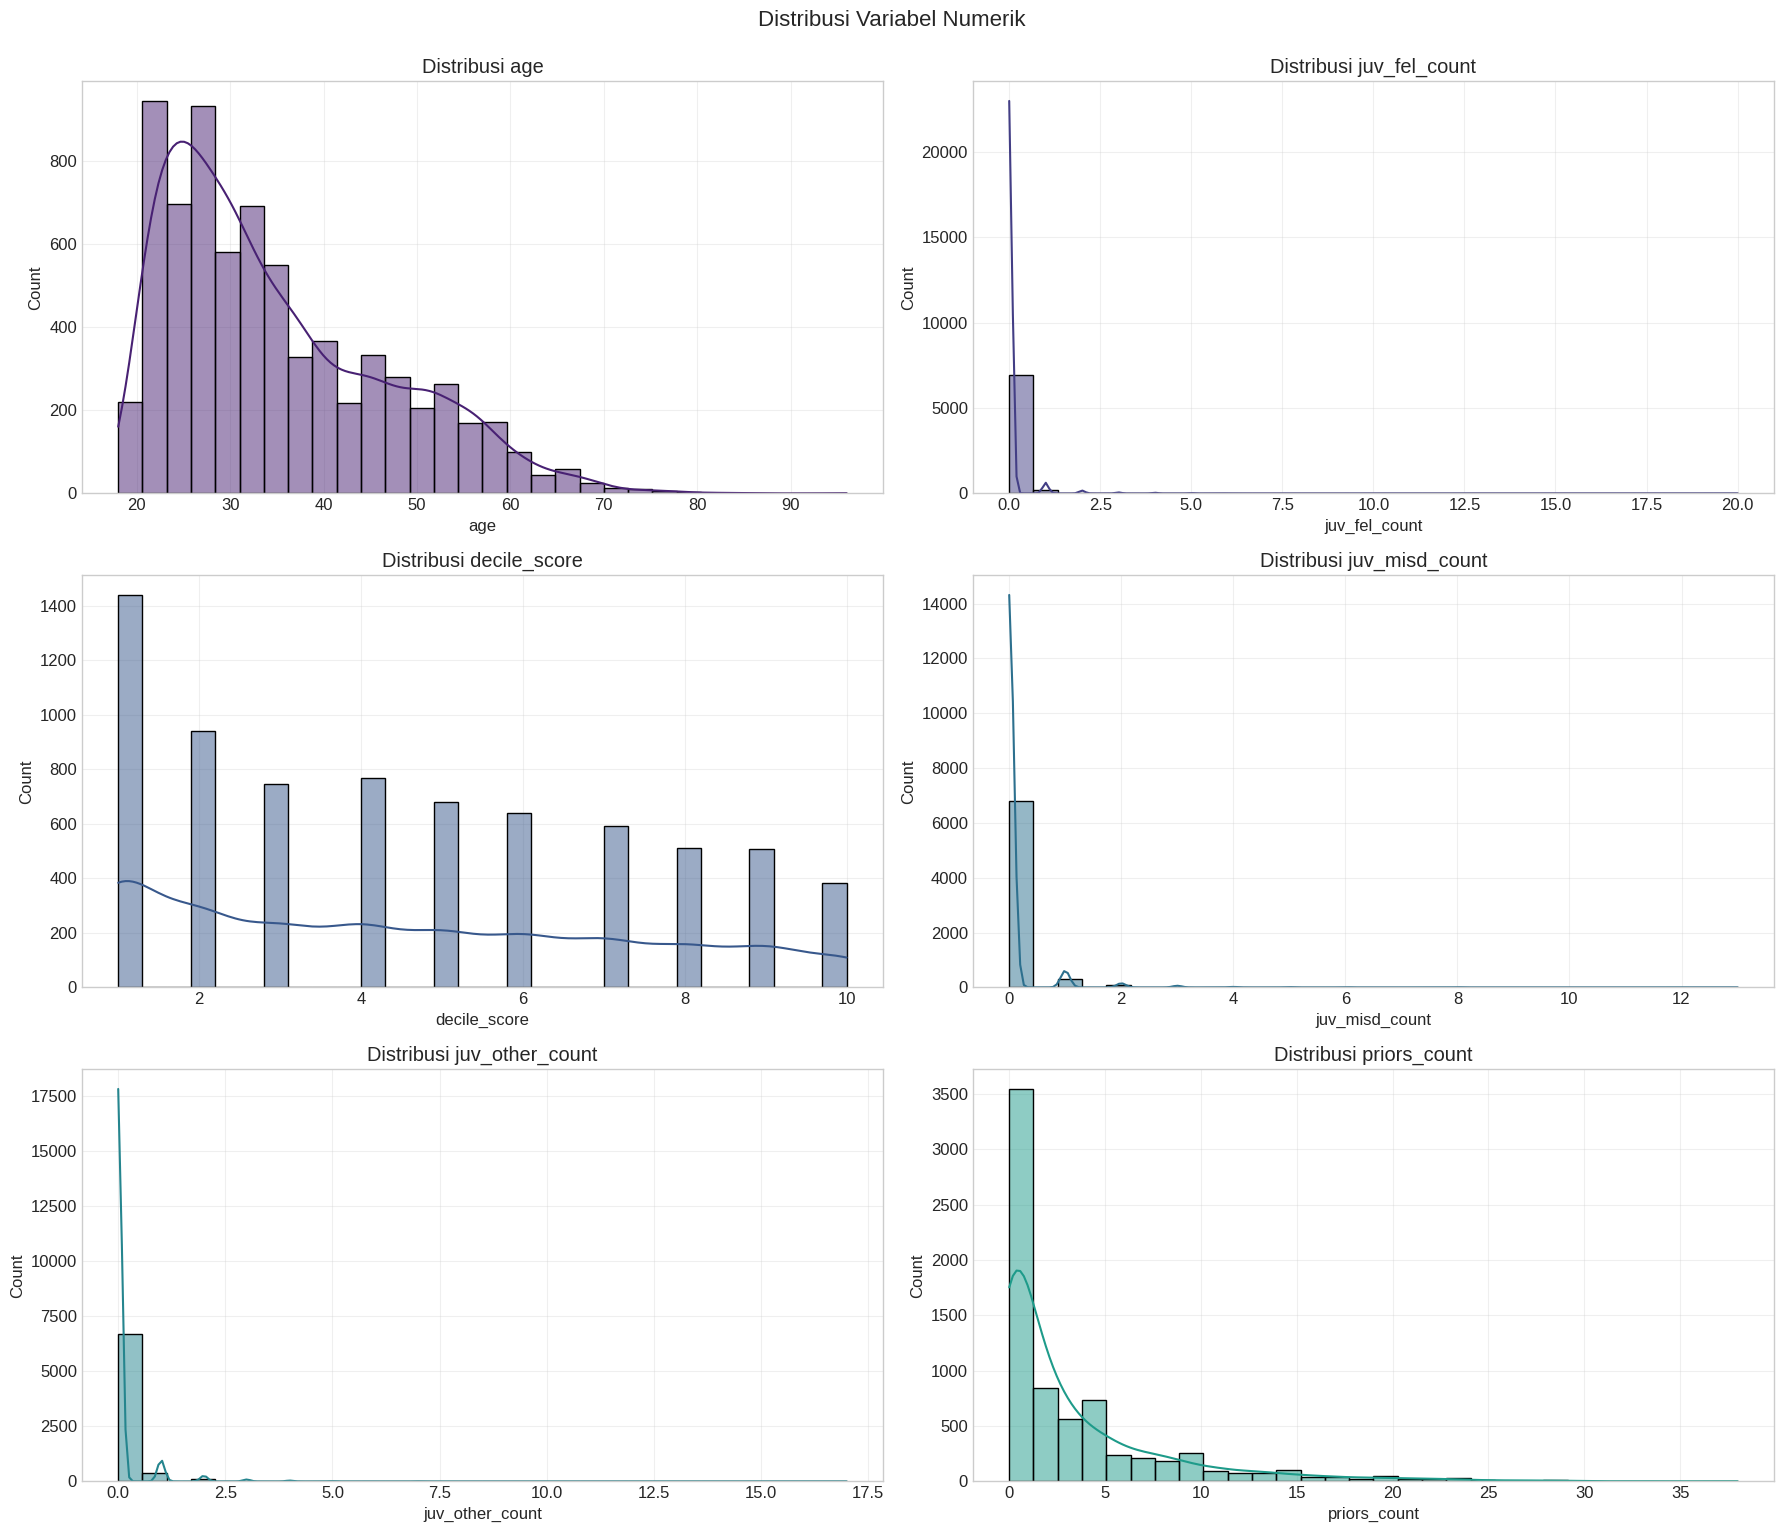

In [35]:
# Visualisasi distribusi variabel numerik
plt.figure(figsize=(18, 15))
for i, col in enumerate(important_num_cols):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[col], kde=True, bins=30, color=colors[i % len(colors)])
    plt.title(f'Distribusi {col}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribusi Variabel Numerik', fontsize=16, y=1.02)
plt.show()

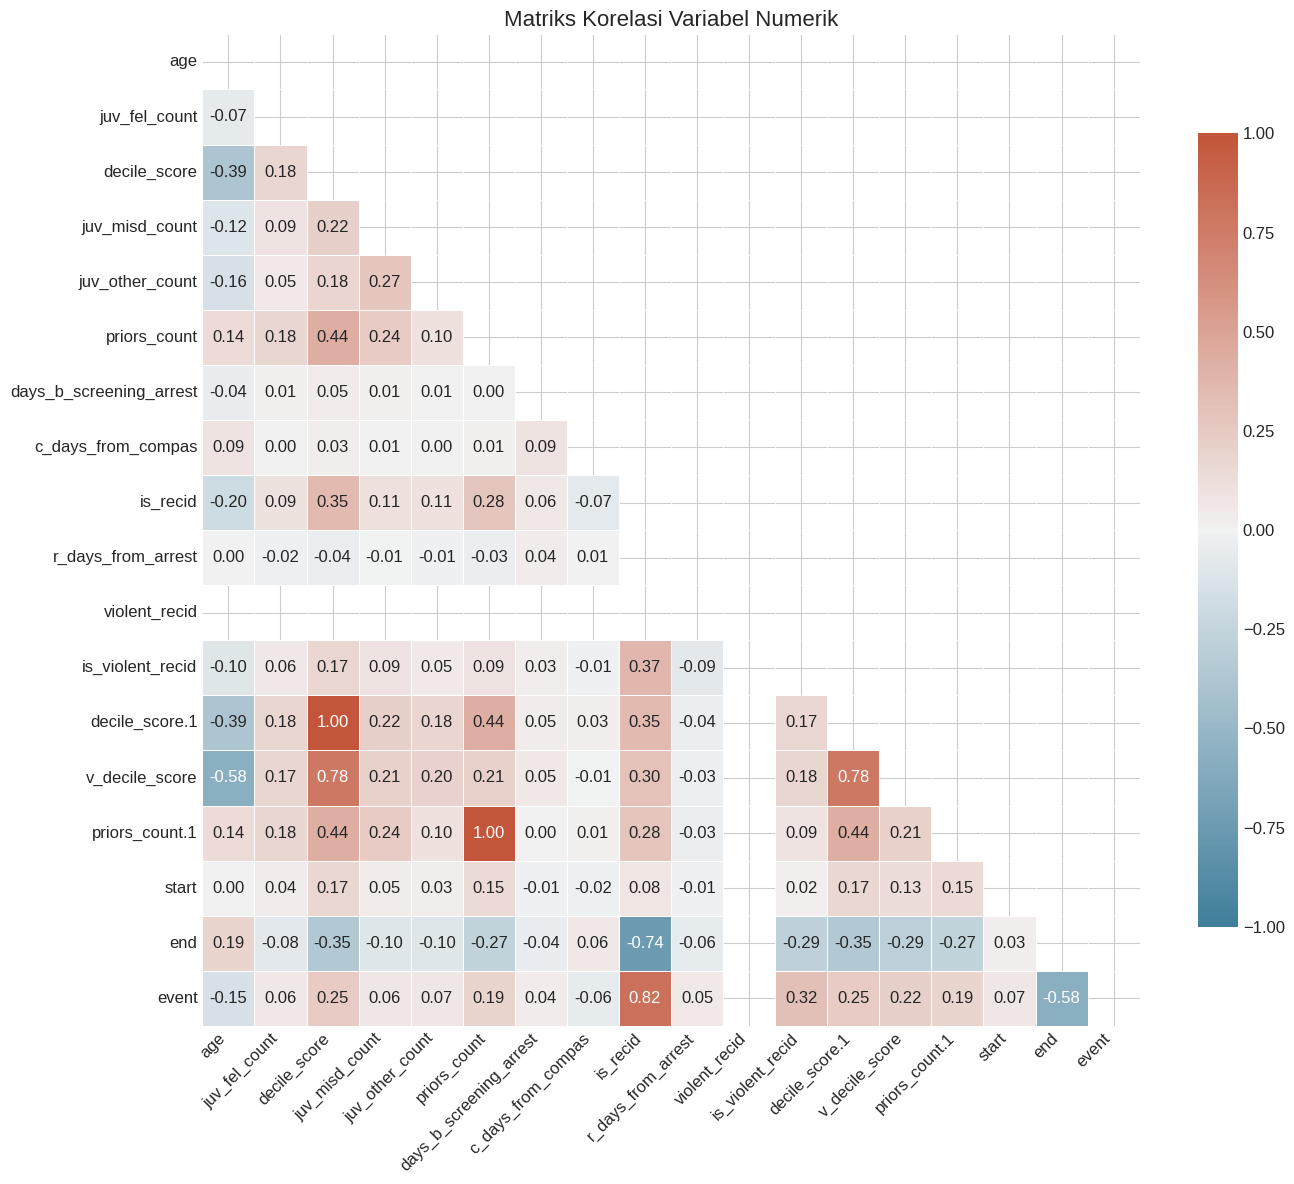

Penjelasan Matriks Korelasi:
1. Korelasi bernilai 1.0 di diagonal karena variabel berkorelasi sempurna dengan dirinya sendiri
2. Nilai korelasi berkisar antara -1 hingga 1:
   - Korelasi positif (mendekati 1): Kedua variabel cenderung meningkat bersama
   - Korelasi negatif (mendekati -1): Saat satu variabel meningkat, yang lain cenderung menurun
   - Korelasi mendekati 0: Hubungan lemah atau tidak ada hubungan linear

Korelasi tertinggi antar variabel:
is_recid dan event: 0.818
event dan is_recid: 0.818
decile_score.1 dan v_decile_score: 0.776
v_decile_score dan decile_score.1: 0.776
decile_score dan v_decile_score: 0.776
v_decile_score dan decile_score: 0.776
end dan is_recid: -0.742
is_recid dan end: -0.742
end dan event: -0.578
event dan end: -0.578


In [36]:
# Korelasi antar variabel numerik
if len(numeric_cols) > 1:
    plt.figure(figsize=(14, 12))
    correlation = df[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(correlation, mask=mask, annot=True, cmap=cmap,
                vmin=-1, vmax=1, center=0, linewidths=0.5, fmt='.2f', cbar_kws={"shrink": .8})

    plt.title('Matriks Korelasi Variabel Numerik', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Penjelasan matriks korelasi
    print("Penjelasan Matriks Korelasi:")
    print("1. Korelasi bernilai 1.0 di diagonal karena variabel berkorelasi sempurna dengan dirinya sendiri")
    print("2. Nilai korelasi berkisar antara -1 hingga 1:")
    print("   - Korelasi positif (mendekati 1): Kedua variabel cenderung meningkat bersama")
    print("   - Korelasi negatif (mendekati -1): Saat satu variabel meningkat, yang lain cenderung menurun")
    print("   - Korelasi mendekati 0: Hubungan lemah atau tidak ada hubungan linear")

    # Menampilkan korelasi tertinggi
    corr_unstack = correlation.unstack()
    corr_filtered = corr_unstack[corr_unstack < 1.0].abs().sort_values(ascending=False)

    if len(corr_filtered) > 0:
        print("\nKorelasi tertinggi antar variabel:")
        for (var1, var2), corr_value in corr_filtered[:10].items():
            print(f"{var1} dan {var2}: {correlation.loc[var1, var2]:.3f}")

## 4. Feature Engineering

Pada bagian ini, kita akan:
1. Menangani nilai yang hilang
2. Mengekstrak fitur dari tanggal
3. Melakukan encoding untuk variabel kategorik
4. Normalisasi fitur numerik
5. Menciptakan fitur baru yang berguna

In [37]:
# Membuat salinan dataframe untuk feature engineering
df_fe = df.copy()

# Menangani nilai yang hilang
for col in numeric_cols:
    if df_fe[col].isnull().sum() > 0:
        median_value = df_fe[col].median()
        print(f"Mengisi nilai yang hilang di kolom {col} dengan median: {median_value}")
        df_fe[col] = df_fe[col].fillna(median_value)

for col in categorical_cols:
    if df_fe[col].isnull().sum() > 0:
        mode_value = df_fe[col].mode()[0]
        print(f"Mengisi nilai yang hilang di kolom {col} dengan mode: {mode_value}")
        df_fe[col] = df_fe[col].fillna(mode_value)

# Memeriksa kembali nilai yang hilang
print("\nNilai yang hilang setelah imputasi:")
print(df_fe.isnull().sum().sum())

Mengisi nilai yang hilang di kolom days_b_screening_arrest dengan median: -1.0
Mengisi nilai yang hilang di kolom c_days_from_compas dengan median: 1.0
Mengisi nilai yang hilang di kolom r_days_from_arrest dengan median: 0.0
Mengisi nilai yang hilang di kolom violent_recid dengan median: nan
Mengisi nilai yang hilang di kolom c_jail_in dengan mode: 2013-01-01 01:31:55
Mengisi nilai yang hilang di kolom c_jail_out dengan mode: 2013-09-12 10:31:00
Mengisi nilai yang hilang di kolom c_case_number dengan mode: 00004068CF10A
Mengisi nilai yang hilang di kolom c_offense_date dengan mode: 2013-01-14
Mengisi nilai yang hilang di kolom c_arrest_date dengan mode: 2013-02-06
Mengisi nilai yang hilang di kolom c_charge_desc dengan mode: Battery
Mengisi nilai yang hilang di kolom r_case_number dengan mode: 13000349MM10A
Mengisi nilai yang hilang di kolom r_charge_degree dengan mode: (M1)
Mengisi nilai yang hilang di kolom r_offense_date dengan mode: 2014-12-08
Mengisi nilai yang hilang di kolom r_c

In [38]:
# Ekstrak fitur dari tanggal (jika ada kolom tanggal)
date_cols = [col for col in df_fe.columns if any(date_keyword in col.lower() for date_keyword in ['date', 'time', 'day'])]

for col in date_cols:
    if df_fe[col].dtype == 'object':
        try:
            df_fe[col] = pd.to_datetime(df_fe[col])
            print(f"Berhasil mengkonversi {col} ke datetime")

            # Ekstrak komponen tanggal
            df_fe[f"{col}_year"] = df_fe[col].dt.year
            df_fe[f"{col}_month"] = df_fe[col].dt.month
            df_fe[f"{col}_day"] = df_fe[col].dt.day
            df_fe[f"{col}_dayofweek"] = df_fe[col].dt.dayofweek

            print(f"Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari {col}")
        except:
            print(f"Gagal mengkonversi {col} ke datetime")

Berhasil mengkonversi compas_screening_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari compas_screening_date
Berhasil mengkonversi c_offense_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari c_offense_date
Berhasil mengkonversi c_arrest_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari c_arrest_date
Berhasil mengkonversi r_offense_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari r_offense_date
Berhasil mengkonversi vr_offense_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari vr_offense_date
Berhasil mengkonversi screening_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari screening_date
Berhasil mengkonversi v_screening_date ke datetime
Berhasil membuat fitur tahun, bulan, hari, dan hari dalam seminggu dari v_screening_date


In [39]:
# Encoding variabel kategorik
for col in categorical_cols:
    if df_fe[col].nunique() <= 10:  # One-hot encoding untuk kategori dengan jumlah nilai yang tidak terlalu banyak
        dummies = pd.get_dummies(df_fe[col], prefix=col, drop_first=True)
        df_fe = pd.concat([df_fe, dummies], axis=1)
        print(f"One-hot encoding untuk {col} dengan {dummies.shape[1]} kolom baru")
    else:  # Label encoding untuk kategori dengan banyak nilai unik
        le = LabelEncoder()
        df_fe[f"{col}_encoded"] = le.fit_transform(df_fe[col])
        print(f"Label encoding untuk {col} -> {col}_encoded")

# Menampilkan ukuran dataframe setelah encoding
print(f"\nUkuran dataframe setelah encoding: {df_fe.shape}")

Label encoding untuk compas_screening_date -> compas_screening_date_encoded
One-hot encoding untuk sex dengan 1 kolom baru
Label encoding untuk dob -> dob_encoded
One-hot encoding untuk age_cat dengan 2 kolom baru
One-hot encoding untuk race dengan 5 kolom baru
Label encoding untuk c_jail_in -> c_jail_in_encoded
Label encoding untuk c_jail_out -> c_jail_out_encoded
Label encoding untuk c_case_number -> c_case_number_encoded
Label encoding untuk c_offense_date -> c_offense_date_encoded
Label encoding untuk c_arrest_date -> c_arrest_date_encoded
One-hot encoding untuk c_charge_degree dengan 1 kolom baru
Label encoding untuk c_charge_desc -> c_charge_desc_encoded
Label encoding untuk r_case_number -> r_case_number_encoded
One-hot encoding untuk r_charge_degree dengan 9 kolom baru
Label encoding untuk r_offense_date -> r_offense_date_encoded
Label encoding untuk r_charge_desc -> r_charge_desc_encoded
Label encoding untuk r_jail_in -> r_jail_in_encoded
Label encoding untuk r_jail_out -> r_j

In [40]:
# Scaling fitur numerik
# Identifikasi kolom numerik yang akan di-scale (tidak termasuk variabel yang sudah di-encoding atau ID)
numeric_cols_to_scale = [col for col in numeric_cols if not (col.endswith('_encoded') or col in exclude_cols)]

scaler = StandardScaler()
df_fe[numeric_cols_to_scale] = scaler.fit_transform(df_fe[numeric_cols_to_scale])

print("Statistik setelah scaling untuk variabel numerik:")
print(df_fe[numeric_cols_to_scale].describe().T[['mean', 'std', 'min', 'max']])

print("\nPenjelasan StandardScaler:")
print("StandardScaler melakukan transformasi dengan mengikuti formula:")
print("X_scaled = (X - μ) / σ")
print("dimana μ adalah rata-rata (mean) dan σ adalah standar deviasi.")
print("Setelah scaling, distribusi data akan memiliki rata-rata = 0 dan standar deviasi = 1")

Statistik setelah scaling untuk variabel numerik:
                                 mean       std       min        max
age                     -4.530769e-17  1.000069 -1.414692   5.146493
juv_fel_count            2.807107e-17  1.000069 -0.141855  42.057698
decile_score            -8.569063e-17  1.000069 -1.228754   1.922288
juv_misd_count           3.841304e-17  1.000069 -0.187414  26.605391
juv_other_count          2.216137e-17  1.000069 -0.218065  33.676791
priors_count             5.170986e-17  1.000069 -0.711240   7.072137
days_b_screening_arrest -1.280435e-17  1.000069 -5.623206  14.207309
c_days_from_compas       1.551296e-17  1.000069 -0.174828  28.634906
is_recid                 3.939799e-18  1.000069 -0.962980   1.038443
r_days_from_arrest      -5.170986e-18  1.000069 -0.172755  22.700698
violent_recid                     NaN       NaN       NaN        NaN
is_violent_recid        -4.186036e-17  1.000069 -0.357867   2.794334
decile_score.1          -8.569063e-17  1.000069 -1.22

In [41]:
# Membuat fitur baru yang mungkin berguna

# 1. Total jumlah kejahatan sebelumnya (jika ada)
crime_count_cols = ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
crime_count_cols_available = [col for col in crime_count_cols if col in df_fe.columns]

if crime_count_cols_available:
    df_fe['total_crimes'] = df_fe[crime_count_cols_available].sum(axis=1)
    print(f"Membuat fitur 'total_crimes' dari {crime_count_cols_available}")
    print(f"Statistik total_crimes:\n{df_fe['total_crimes'].describe()}")

# 2. Rasio antara beberapa fitur penting (jika tersedia)
if 'juv_fel_count' in df_fe.columns and 'juv_misd_count' in df_fe.columns:
    # Menghindari pembagian dengan nol dengan menambahkan 1
    df_fe['felony_to_misdemeanor_ratio'] = (df_fe['juv_fel_count'] + 1) / (df_fe['juv_misd_count'] + 1)
    print(f"Membuat fitur 'felony_to_misdemeanor_ratio'")

# 3. Kategori usia (jika ada kolom usia)
if 'age' in df_fe.columns:
    bins = [0, 18, 25, 35, 45, 55, 100]
    labels = ['0-18', '19-25', '26-35', '36-45', '46-55', '55+']
    df_fe['age_group'] = pd.cut(df_fe['age'], bins=bins, labels=labels)

    # One-hot encoding untuk age_group
    age_dummies = pd.get_dummies(df_fe['age_group'], prefix='age_group')
    df_fe = pd.concat([df_fe, age_dummies], axis=1)
    print(f"Membuat kategori usia dan {len(labels)} kolom dummy")

# 4. Interaksi antar fitur (jika relevan)
if 'race' in df_fe.columns and 'sex' in df_fe.columns:
    df_fe['race_sex'] = df_fe['race'] + '_' + df_fe['sex']
    print(f"Membuat fitur interaksi 'race_sex'")

    # Label encoding untuk kombinasi race_sex
    le_race_sex = LabelEncoder()
    df_fe['race_sex_encoded'] = le_race_sex.fit_transform(df_fe['race_sex'])

    print(f"Nilai unik race_sex: {df_fe['race_sex'].nunique()}")

Membuat fitur 'total_crimes' dari ['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count']
Statistik total_crimes:
count    7.214000e+03
mean     1.694114e-16
std      2.422805e+00
min     -1.258573e+00
25%     -1.258573e+00
50%     -8.489221e-01
75%      1.752064e-01
max      4.585680e+01
Name: total_crimes, dtype: float64
Membuat fitur 'felony_to_misdemeanor_ratio'
Membuat kategori usia dan 6 kolom dummy
Membuat fitur interaksi 'race_sex'
Nilai unik race_sex: 12


In [42]:
# Deteksi outlier dengan metode IQR
outliers_count = {}

for col in numeric_cols_to_scale:
    # Menghitung Q1, Q3, dan IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Menentukan batas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menghitung jumlah outlier
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
    outliers_count[col] = outliers

    # Menambahkan flag outlier
    df_fe[f"{col}_is_outlier"] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)

# Menampilkan jumlah outlier untuk setiap variabel
outliers_df = pd.DataFrame({
    'Jumlah Outlier': outliers_count,
    'Persentase (%)': {k: v/len(df)*100 for k, v in outliers_count.items()}
})

print("Penjelasan Metode IQR untuk deteksi outlier:")
print("1. Q1 (kuartil pertama): 25% data berada di bawah nilai ini")
print("2. Q3 (kuartil ketiga): 75% data berada di bawah nilai ini")
print("3. IQR (Inter-Quartile Range): Selisih antara Q3 dan Q1")
print("4. Batas bawah outlier: Q1 - 1.5 * IQR")
print("5. Batas atas outlier: Q3 + 1.5 * IQR")
print("\nData di luar batas ini dianggap sebagai outlier.\n")

outliers_df.sort_values('Jumlah Outlier', ascending=False)

Penjelasan Metode IQR untuk deteksi outlier:
1. Q1 (kuartil pertama): 25% data berada di bawah nilai ini
2. Q3 (kuartil ketiga): 75% data berada di bawah nilai ini
3. IQR (Inter-Quartile Range): Selisih antara Q3 dan Q1
4. Batas bawah outlier: Q1 - 1.5 * IQR
5. Batas atas outlier: Q3 + 1.5 * IQR

Data di luar batas ini dianggap sebagai outlier.



,Jumlah Outlier,Persentase (%)
start,1560,21.624619
c_days_from_compas,1546,21.430552
days_b_screening_arrest,1397,19.365123
is_violent_recid,819,11.352925
juv_other_count,523,7.249792
priors_count.1,455,6.307180
priors_count,455,6.307180
juv_misd_count,415,5.752703
r_days_from_arrest,343,4.754644
juv_fel_count,282,3.909066


Melewati kolom 'age_group' karena bukan numerik atau target bukan numerik


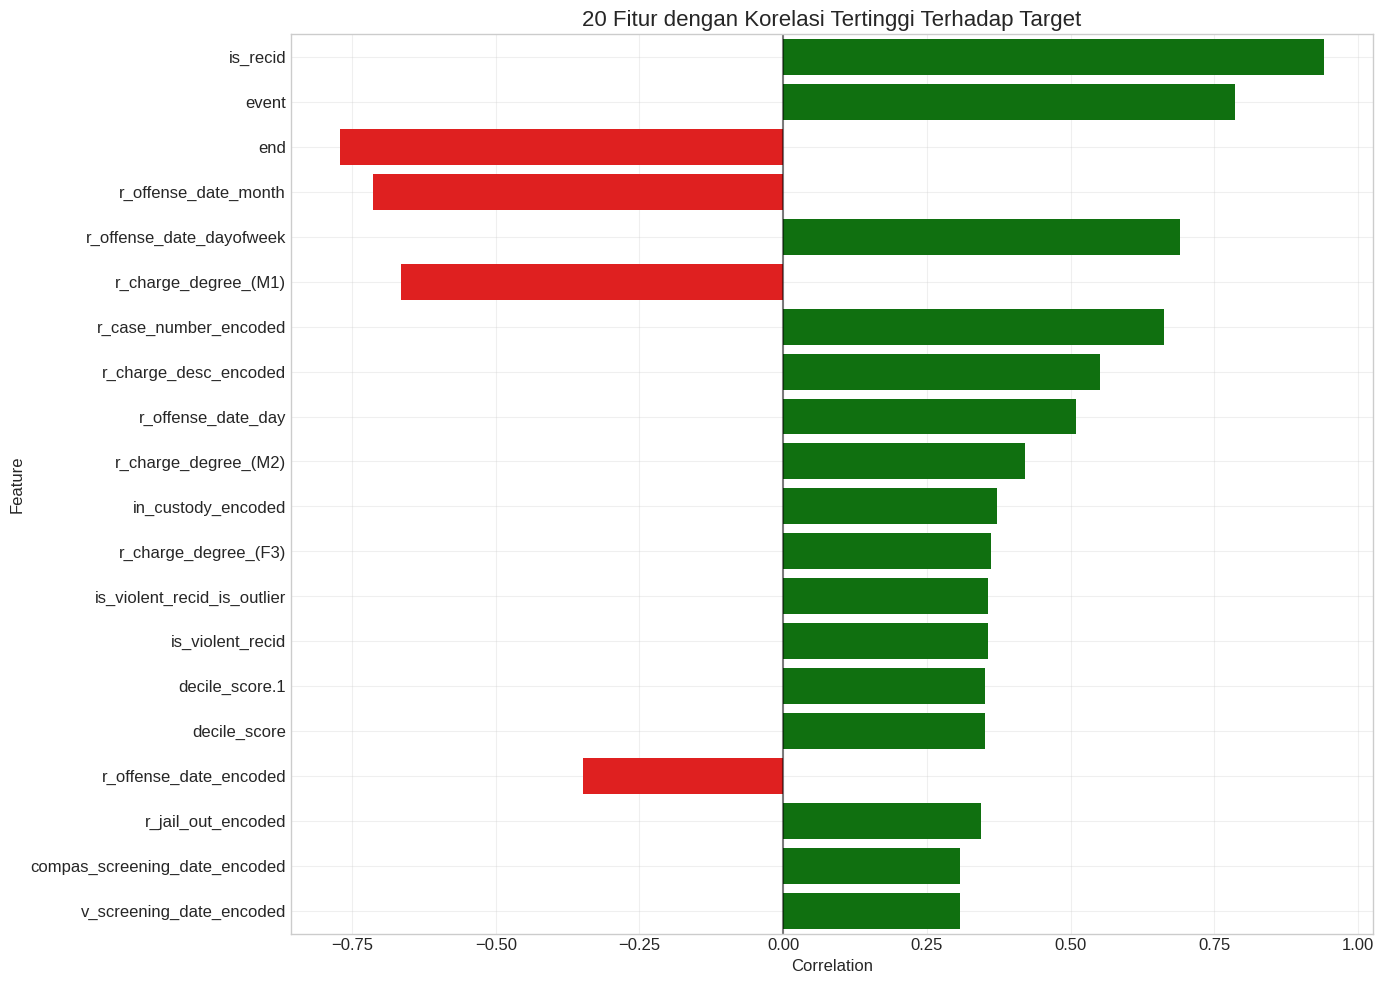

Fitur dengan korelasi tertinggi terhadap target:
                          Feature  Correlation  Abs_Correlation
0                        is_recid     0.940544         0.940544
1                           event     0.785957         0.785957
2                             end    -0.770794         0.770794
3            r_offense_date_month    -0.712989         0.712989
4        r_offense_date_dayofweek     0.690257         0.690257
5            r_charge_degree_(M1)    -0.664140         0.664140
6           r_case_number_encoded     0.663119         0.663119
7           r_charge_desc_encoded     0.550964         0.550964
8              r_offense_date_day     0.509692         0.509692
9            r_charge_degree_(M2)     0.421373         0.421373
10             in_custody_encoded     0.371439         0.371439
11           r_charge_degree_(F3)     0.362250         0.362250
12    is_violent_recid_is_outlier     0.356476         0.356476
13               is_violent_recid     0.356476         

In [43]:
# Analisis fitur yang paling berkorelasi dengan target
# Mengambil semua kolom kecuali yang bersifat ID atau kategori asli yang sudah di-encode
feature_cols = [col for col in df_fe.columns
                if col not in exclude_cols and
                col != target_col and
                not (col in categorical_cols or col in date_cols or col.startswith('race_sex')) and
                df_fe[col].dtype != 'object']  # Pastikan hanya kolom numerik

# Pastikan target_col sudah numerik
if df_fe[target_col].dtype == 'object':
    print(f"Variabel target '{target_col}' masih berupa kategorikal, menggunakan encoded version")
    # Gunakan versi yang sudah diencode
    target_col_numeric = f"{target_col}_encoded" if f"{target_col}_encoded" in df_fe.columns else target_col
else:
    target_col_numeric = target_col

# Hitung korelasi dengan target
correlations = {}
for col in feature_cols:
    # Pastikan kedua kolom adalah numerik
    if pd.api.types.is_numeric_dtype(df_fe[col]) and pd.api.types.is_numeric_dtype(df_fe[target_col_numeric]):
        correlations[col] = np.corrcoef(df_fe[col], df_fe[target_col_numeric])[0, 1]
    else:
        print(f"Melewati kolom '{col}' karena bukan numerik atau target bukan numerik")

# Buat DataFrame untuk visualisasi
corr_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
corr_df['Abs_Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Visualisasi 20 fitur dengan korelasi tertinggi
plt.figure(figsize=(14, 10))
top_features = corr_df.head(20)
colors = ['red' if x < 0 else 'green' for x in top_features['Correlation']]

sns.barplot(x='Correlation', y='Feature', data=top_features, palette=colors)
plt.title('20 Fitur dengan Korelasi Tertinggi Terhadap Target', fontsize=16)
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Fitur dengan korelasi tertinggi terhadap target:")
print(corr_df.head(20))

## 5. Pemodelan dan Evaluasi

Pada bagian ini, kita akan membagi data menjadi training dan testing set, kemudian melatih beberapa model klasifikasi dan mengevaluasi performanya menggunakan berbagai metrik.

In [44]:
# Persiapan data sebelum pemodelan - tambahkan kode ini sebelum bagian evaluasi model
# Menyiapkan data untuk pemodelan
X = df_fe.drop(['Diagnosis', 'Diagnosis_encoded'] if 'Diagnosis' in df_fe.columns else [target_col], axis=1)

# Hapus kolom yang berisi data kategorik (object)
object_columns = X.select_dtypes(include=['object']).columns
if not object_columns.empty:
    print(f"Menghapus kolom dengan tipe data object: {list(object_columns)}")
    X = X.drop(object_columns, axis=1)

# Periksa kolom age_group_ jika ada
age_group_cols = [col for col in X.columns if 'age_group' in col and isinstance(col, str) and not col.startswith('age_group_')]
if age_group_cols:
    print(f"Menghapus kolom age_group yang masih kategorik: {age_group_cols}")
    X = X.drop(age_group_cols, axis=1)



# Hapus kolom-kolom bermasalah sekaligus
if column_to_drop:
    print(f"Menghapus kolom yang tidak bisa dikonversi ke float: {column_to_drop}")
    X = X.drop(column_to_drop, axis=1)

# Konfirmasi bahwa semua data sekarang numerik
print("Tipe data setiap kolom setelah pembersihan:")
print(X.dtypes.value_counts())

y = df_fe[target_col] if 'Diagnosis_encoded' not in df_fe.columns else df_fe['Diagnosis_encoded']

# Pastikan y juga numerik
if not pd.api.types.is_numeric_dtype(y):
    print("Mengkonversi target ke numerik...")
    le = LabelEncoder()
    y = le.fit_transform(y)
    print(f"Pemetaan label: {dict(zip(le.classes_, range(len(le.classes_))))}")
# Membagi data menjadi training dan testing set (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Jumlah data training: {X_train.shape[0]} ({X_train.shape[0]/len(df):.1%})")
print(f"Jumlah data testing: {X_test.shape[0]} ({X_test.shape[0]/len(df):.1%})")
print(f"Jumlah fitur: {X_train.shape[1]}")
print(f"Distribusi kelas pada data training:\n{y_train.value_counts()}")
print(f"Distribusi kelas pada data testing:\n{y_test.value_counts()}")

Menghapus kolom dengan tipe data object: ['name', 'first', 'last', 'sex', 'dob', 'age_cat', 'race', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_charge_degree', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'vr_case_number', 'vr_charge_degree', 'vr_charge_desc', 'type_of_assessment', 'score_text', 'v_type_of_assessment', 'v_score_text', 'in_custody', 'out_custody', 'race_sex']
Menghapus kolom age_group yang masih kategorik: ['age_group']
Tipe data setiap kolom setelah pembersihan:
int64             40
bool              36
int32             28
float64           20
datetime64[ns]     7
Name: count, dtype: int64
Jumlah data training: 5771 (80.0%)
Jumlah data testing: 1443 (20.0%)
Jumlah fitur: 131
Distribusi kelas pada data training:
two_year_recid
0    3170
1    2601
Name: count, dtype: int64
Distribusi kelas pada data testing:
two_year_recid
0    793
1    650
Name: count, dtype: int64


### Penjelasan Metrik Evaluasi Klasifikasi

Berikut penjelasan detail tentang metrik-metrik yang akan kita gunakan untuk evaluasi model klasifikasi:

In [45]:
print("Penjelasan Metrik Evaluasi Klasifikasi:\n")

print("1. Confusion Matrix:")
print("   Matrix 2x2 yang menunjukkan prediksi vs nilai aktual, terdiri dari:")
print("   - True Positive (TP): Positif yang diprediksi benar sebagai positif")
print("   - True Negative (TN): Negatif yang diprediksi benar sebagai negatif")
print("   - False Positive (FP): Negatif yang salah diprediksi sebagai positif (Type I error)")
print("   - False Negative (FN): Positif yang salah diprediksi sebagai negatif (Type II error)\n")

print("2. Akurasi (Accuracy):")
print("   Akurasi = (TP + TN) / (TP + TN + FP + FN)")
print("   Proporsi total prediksi yang benar. Semakin tinggi nilainya, semakin baik model.")
print("   Kekurangan: Tidak efektif untuk data yang tidak seimbang (imbalanced).\n")

print("3. Presisi (Precision):")
print("   Presisi = TP / (TP + FP)")
print("   Mengukur seberapa akurat prediksi positif model. Dari semua yang diprediksi positif, berapa yang benar-benar positif.")
print("   Gunakan saat biaya false positive tinggi.\n")

print("4. Recall (Sensitivity, True Positive Rate):")
print("   Recall = TP / (TP + FN)")
print("   Mengukur kemampuan model untuk mendeteksi kelas positif. Dari semua yang sebenarnya positif, berapa yang berhasil diprediksi benar.")
print("   Gunakan saat biaya false negative tinggi.\n")

print("5. F1-Score:")
print("   F1 = 2 * (Precision * Recall) / (Precision + Recall)")
print("   Rata-rata harmonik dari presisi dan recall. Menyeimbangkan kedua metrik.")
print("   Baik digunakan saat data tidak seimbang atau ketika ingin menyeimbangkan presisi dan recall.\n")

print("6. AUC (Area Under the Curve):")
print("   Mengukur area di bawah kurva ROC. Nilai antara 0 dan 1.")
print("   AUC = 1: Pengklasifikasi sempurna")
print("   AUC = 0.5: Tidak lebih baik dari tebakan acak")
print("   AUC < 0.5: Kinerja lebih buruk dari tebakan acak\n")

print("7. ROC Curve (Receiver Operating Characteristic):")
print("   Plot yang menunjukkan performa model klasifikasi pada semua threshold.")
print("   Plot antara True Positive Rate (Recall) vs False Positive Rate.")
print("   False Positive Rate = FP / (FP + TN)")
print("   Berguna untuk memilih threshold yang optimal berdasarkan kebutuhan bisnis.")

Penjelasan Metrik Evaluasi Klasifikasi:

1. Confusion Matrix:
   Matrix 2x2 yang menunjukkan prediksi vs nilai aktual, terdiri dari:
   - True Positive (TP): Positif yang diprediksi benar sebagai positif
   - True Negative (TN): Negatif yang diprediksi benar sebagai negatif
   - False Positive (FP): Negatif yang salah diprediksi sebagai positif (Type I error)
   - False Negative (FN): Positif yang salah diprediksi sebagai negatif (Type II error)

2. Akurasi (Accuracy):
   Akurasi = (TP + TN) / (TP + TN + FP + FN)
   Proporsi total prediksi yang benar. Semakin tinggi nilainya, semakin baik model.
   Kekurangan: Tidak efektif untuk data yang tidak seimbang (imbalanced).

3. Presisi (Precision):
   Presisi = TP / (TP + FP)
   Mengukur seberapa akurat prediksi positif model. Dari semua yang diprediksi positif, berapa yang benar-benar positif.
   Gunakan saat biaya false positive tinggi.

4. Recall (Sensitivity, True Positive Rate):
   Recall = TP / (TP + FN)
   Mengukur kemampuan model unt

In [46]:
# Definisi fungsi untuk mengevaluasi model
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    # Melatih model
    model.fit(X_train, y_train)

    # Prediksi pada data training dan testing
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Menghitung metrik evaluasi
    results = {}

    # Akurasi
    results['train_accuracy'] = accuracy_score(y_train, y_train_pred)
    results['test_accuracy'] = accuracy_score(y_test, y_test_pred)

    # Presisi
    results['train_precision'] = precision_score(y_train, y_train_pred, average='weighted')
    results['test_precision'] = precision_score(y_test, y_test_pred, average='weighted')

    # Recall
    results['train_recall'] = recall_score(y_train, y_train_pred, average='weighted')
    results['test_recall'] = recall_score(y_test, y_test_pred, average='weighted')

    # F1-Score
    results['train_f1'] = f1_score(y_train, y_train_pred, average='weighted')
    results['test_f1'] = f1_score(y_test, y_test_pred, average='weighted')

    # Confusion Matrix
    results['test_confusion_matrix'] = confusion_matrix(y_test, y_test_pred)

    # AUC - hanya jika model mendukung predict_proba
    if hasattr(model, "predict_proba"):
        try:
            # Untuk binary classification
            y_train_prob = model.predict_proba(X_train)[:, 1]
            y_test_prob = model.predict_proba(X_test)[:, 1]

            results['train_auc'] = roc_auc_score(y_train, y_train_prob)
            results['test_auc'] = roc_auc_score(y_test, y_test_prob)
            results['test_prob'] = y_test_prob
        except:
            print(f"AUC calculation not supported for {model_name}")
            results['train_auc'] = None
            results['test_auc'] = None
            results['test_prob'] = None
    else:
        results['train_auc'] = None
        results['test_auc'] = None
        results['test_prob'] = None

    # Menyimpan prediksi dan model
    results['model'] = model
    results['test_pred'] = y_test_pred

    return results

In [47]:
# Melatih dan mengevaluasi berbagai model klasifikasi
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Evaluasi model: {name}")
    results[name] = evaluate_classification_model(model, X_train, X_test, y_train, y_test, name)
    print(f"  Akurasi (Train): {results[name]['train_accuracy']:.4f}")
    print(f"  Akurasi (Test): {results[name]['test_accuracy']:.4f}")
    print(f"  Presisi (Train): {results[name]['train_precision']:.4f}")
    print(f"  Presisi (Test): {results[name]['test_precision']:.4f}")
    print(f"  Recall (Train): {results[name]['train_recall']:.4f}")
    print(f"  Recall (Test): {results[name]['test_recall']:.4f}")
    print(f"  F1-Score (Train): {results[name]['train_f1']:.4f}")
    print(f"  F1-Score (Test): {results[name]['test_f1']:.4f}")
    if results[name]['train_auc'] is not None:
        print(f"  AUC (Train): {results[name]['train_auc']:.4f}")
        print(f"  AUC (Test): {results[name]['test_auc']:.4f}")
    print("")

Evaluasi model: Logistic Regression


DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.BoolDType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>)

In [ ]:
# Visualisasi perbandingan model
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
datasets = ['train', 'test']

# Membuat DataFrame untuk visualisasi
results_df = pd.DataFrame()

for name in results:
    for metric in metrics:
        for dataset in datasets:
            metric_name = f"{dataset}_{metric}"
            if metric_name in results[name] and results[name][metric_name] is not None:
                results_df.loc[name, metric_name] = results[name][metric_name]

# Plot bar chart untuk semua metrik
fig, axes = plt.subplots(len(metrics), 1, figsize=(14, 4*len(metrics)))
fig.suptitle('Perbandingan Metrik Model', fontsize=20, y=0.95)

for i, metric in enumerate(metrics):
    # Skip if metric not applicable
    if f"train_{metric}" not in results_df.columns or f"test_{metric}" not in results_df.columns:
        continue

    train_metric = f"train_{metric}"
    test_metric = f"test_{metric}"

    # Filter out models that don't have this metric
    valid_models = results_df[results_df[train_metric].notna() & results_df[test_metric].notna()].index

    if len(valid_models) == 0:
        continue

    barWidth = 0.4
    r1 = np.arange(len(valid_models))
    r2 = [x + barWidth for x in r1]

    axes[i].bar(r1, results_df.loc[valid_models, train_metric], width=barWidth, label=f'Train {metric.upper()}', color='skyblue')
    axes[i].bar(r2, results_df.loc[valid_models, test_metric], width=barWidth, label=f'Test {metric.upper()}', color='salmon')
    axes[i].set_xlabel('Model', fontsize=12)
    axes[i].set_ylabel(metric.upper(), fontsize=12)
    axes[i].set_title(f'Perbandingan {metric.upper()}', fontsize=14)
    axes[i].set_xticks([r + barWidth/2 for r in range(len(valid_models))])
    axes[i].set_xticklabels(valid_models, rotation=45, ha='right')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

    # Menambahkan nilai di atas bar
    for j, model in enumerate(valid_models):
        axes[i].text(r1[j], results_df.loc[model, train_metric] + 0.01, f'{results_df.loc[model, train_metric]:.3f}',
                    ha='center', va='bottom', fontsize=9)
        axes[i].text(r2[j], results_df.loc[model, test_metric] + 0.01, f'{results_df.loc[model, test_metric]:.3f}',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In [ ]:
# Visualisasi Confusion Matrix untuk setiap model
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Confusion Matrix untuk Setiap Model', fontsize=20, y=0.95)
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    if i < len(axes):
        cm = result['test_confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix - {name}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

        # Menghitung dan menampilkan metrik per kelas
        tn, fp, fn, tp = cm.ravel() if cm.shape == (2, 2) else (None, None, None, None)
        if None not in (tn, fp, fn, tp):
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0
            axes[i].text(0.5, -0.15,
                         f"Specificity: {specificity:.3f}, NPV: {npv:.3f}",
                         ha='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

In [ ]:
# Plotting ROC Curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    if result['test_prob'] is not None:
        fpr, tpr, _ = roc_curve(y_test, result['test_prob'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Penjelasan ROC Curve:")
print("1. ROC curve menampilkan trade-off antara True Positive Rate (TPR atau recall) dan False Positive Rate (FPR).")
print("2. AUC (Area Under Curve) mengukur keseluruhan performa model. Nilai 1.0 adalah sempurna, 0.5 adalah sama dengan menebak acak.")
print("3. Model yang ideal memiliki kurva yang menjauhi garis diagonal (random guess) dan mendekati sudut kiri atas (TPR=1, FPR=0).")

## 6. Analisis Model Terbaik dan Fitur Penting

In [ ]:
# Identifikasi model terbaik berdasarkan akurasi test
best_model_name = results_df['test_accuracy'].idxmax()
best_model = results[best_model_name]['model']

print(f"Model dengan akurasi test terbaik: {best_model_name}")
print(f"Akurasi test: {results_df.loc[best_model_name, 'test_accuracy']:.4f}")
print(f"Presisi test: {results_df.loc[best_model_name, 'test_precision']:.4f}")
print(f"Recall test: {results_df.loc[best_model_name, 'test_recall']:.4f}")
print(f"F1-Score test: {results_df.loc[best_model_name, 'test_f1']:.4f}")
if 'test_auc' in results_df.columns and pd.notna(results_df.loc[best_model_name, 'test_auc']):
    print(f"AUC test: {results_df.loc[best_model_name, 'test_auc']:.4f}")

In [ ]:
# Analisis fitur penting dari model terbaik
# Jika model mendukung feature_importances_ atau coef_
feature_importance = None

if hasattr(best_model, 'feature_importances_'):
    # Untuk Random Forest, Gradient Boosting, dll
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    })
elif hasattr(best_model, 'coef_'):
    # Untuk Logistic Regression
    # Mengambil nilai absolut dari koefisien untuk menunjukkan pentingnya fitur
    importances = np.abs(best_model.coef_[0]) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    })

if feature_importance is not None:
    # Mengurutkan berdasarkan kepentingan fitur
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)

    # Visualisasi 20 fitur teratas
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
    plt.title(f'20 Fitur Terpenting ({best_model_name})', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Menampilkan 20 fitur teratas
    print("20 Fitur Terpenting:")
    print(feature_importance.head(20))
else:
    print(f"Model {best_model_name} tidak mendukung analisis fitur penting secara langsung.")

## 7. Analisis Bias dalam Model COMPAS

Dataset COMPAS telah menjadi subjek diskusi penting tentang bias algoritma dalam sistem peradilan.
Kita akan menganalisis apakah model kita menunjukkan bias terhadap kelompok tertentu, terutama berdasarkan ras.

In [ ]:
# Analisis bias berdasarkan ras (jika 'race' tersedia)
if 'race' in df.columns:
    # Menggunakan model terbaik untuk prediksi
    y_pred = best_model.predict(X_test)

    # Membuat dataframe untuk analisis
    bias_df = pd.DataFrame({
        'race': df.loc[y_test.index, 'race'],
        'actual': y_test,
        'predicted': y_pred
    })

    # Menghitung metrik per ras
    metrics_by_race = {}
    for race_group in bias_df['race'].unique():
        race_data = bias_df[bias_df['race'] == race_group]

        metrics_by_race[race_group] = {
            'count': len(race_data),
            'accuracy': accuracy_score(race_data['actual'], race_data['predicted']),
            'precision': precision_score(race_data['actual'], race_data['predicted'], zero_division=0),
            'recall': recall_score(race_data['actual'], race_data['predicted'], zero_division=0),
            'f1': f1_score(race_data['actual'], race_data['predicted'], zero_division=0),
            'false_positive_rate': (race_data[(race_data['actual'] == 0) & (race_data['predicted'] == 1)].shape[0] /
                                  max(1, race_data[race_data['actual'] == 0].shape[0])),
            'false_negative_rate': (race_data[(race_data['actual'] == 1) & (race_data['predicted'] == 0)].shape[0] /
                                  max(1, race_data[race_data['actual'] == 1].shape[0]))
        }

    # Membuat DataFrame untuk visualisasi
    metrics_df = pd.DataFrame(metrics_by_race).T.reset_index()
    metrics_df = metrics_df.rename(columns={'index': 'race'}).sort_values('count', ascending=False)

    # Visualisasi metrik per ras
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'false_positive_rate', 'false_negative_rate']

    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        sns.barplot(x='race', y=metric, data=metrics_df, ax=axes[i], palette='viridis')
        axes[i].set_title(f'{metric} per Ras')
        axes[i].set_xlabel('Ras')
        axes[i].set_ylabel(metric)
        axes[i].tick_params(axis='x', rotation=45)

        # Menambahkan label nilai
        for j, v in enumerate(metrics_df[metric]):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.suptitle('Analisis Bias Berdasarkan Ras', fontsize=16, y=1.02)
    plt.show()

    # Menampilkan statistik per ras
    print("Statistik per Ras:")
    print(metrics_df)

    # Menilai disparitas dalam False Positive Rate dan False Negative Rate
    print("\nDisparitas dalam False Positive Rate (FPR) dan False Negative Rate (FNR):")

    # Menghitung rata-rata tertimbang
    weighted_avg_fpr = (metrics_df['false_positive_rate'] * metrics_df['count']).sum() / metrics_df['count'].sum()
    weighted_avg_fnr = (metrics_df['false_negative_rate'] * metrics_df['count']).sum() / metrics_df['count'].sum()

    print(f"Rata-rata tertimbang FPR: {weighted_avg_fpr:.3f}")
    print(f"Rata-rata tertimbang FNR: {weighted_avg_fnr:.3f}")

    # Menghitung disparitas relatif terhadap rata-rata
    metrics_df['fpr_disparity'] = metrics_df['false_positive_rate'] / weighted_avg_fpr
    metrics_df['fnr_disparity'] = metrics_df['false_negative_rate'] / weighted_avg_fnr

    print("\nDisparitas relatif terhadap rata-rata:")
    print(metrics_df[['race', 'count', 'fpr_disparity', 'fnr_disparity']].sort_values('fpr_disparity', ascending=False))

    # Interpretasi
    print("\nInterpretasi:")
    print("- Nilai disparitas > 1 menunjukkan kelompok memiliki tingkat error lebih tinggi dari rata-rata")
    print("- Nilai disparitas < 1 menunjukkan kelompok memiliki tingkat error lebih rendah dari rata-rata")
    print("- FPR tinggi berarti lebih banyak individu diprediksi positif padahal sebenarnya negatif (over-prediction)")
    print("- FNR tinggi berarti lebih banyak individu diprediksi negatif padahal sebenarnya positif (under-prediction)")
else:
    print("Variabel 'race' tidak tersedia untuk analisis bias.")

## 8. Cross-Validation dan Hyperparameter Tuning untuk Model Terbaik

In [ ]:
# Cross-validation untuk model terbaik
print(f"Melakukan cross-validation untuk model {best_model_name}...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Metrik yang dievaluasi
cv_metrics = {'accuracy': 'accuracy', 'precision': 'precision_weighted',
             'recall': 'recall_weighted', 'f1': 'f1_weighted'}

cv_results = {}
for metric_name, scoring in cv_metrics.items():
    cv_scores = cross_val_score(best_model, X, y, cv=cv, scoring=scoring)
    cv_results[metric_name] = {
        'scores': cv_scores,
        'mean': np.mean(cv_scores),
        'std': np.std(cv_scores)
    }

# Tampilkan hasil cross-validation
for metric_name, result in cv_results.items():
    print(f"{metric_name.capitalize()} pada 5-fold CV: {result['mean']:.4f} ± {result['std']:.4f}")
    print(f"Skor individual: {result['scores']}")
    print("")

In [ ]:
# Hyperparameter tuning untuk model terbaik
# Definisikan parameter grid berdasarkan model terbaik

if best_model_name == 'Logistic Regression':
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['lbfgs', 'liblinear', 'saga']
    }
    # Penjelasan parameter:
    print("Parameter Logistic Regression:")
    print("1. C: Inverse regularization strength. Nilai rendah berarti regularisasi kuat.")
    print("2. penalty: Jenis regularisasi. L1 cenderung menghasilkan model yang sparse, L2 mengurangi overfitting.")
    print("3. solver: Algoritma yang digunakan untuk optimasi.")

elif best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    # Penjelasan parameter:
    print("Parameter Random Forest:")
    print("1. n_estimators: Jumlah pohon (trees) dalam forest.")
    print("2. max_depth: Kedalaman maksimum setiap pohon. None berarti tidak dibatasi.")
    print("3. min_samples_split: Jumlah minimum sampel yang dibutuhkan untuk membagi node internal.")
    print("4. min_samples_leaf: Jumlah minimum sampel yang dibutuhkan di node daun.")

elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 0.9, 1.0]
    }
    # Penjelasan parameter:
    print("Parameter Gradient Boosting:")
    print("1. n_estimators: Jumlah boosting stages (pohon).")
    print("2. learning_rate: Tingkat kontribusi setiap pohon pada model akhir.")
    print("3. max_depth: Kedalaman maksimum setiap pohon.")
    print("4. subsample: Fraksi sampel yang digunakan untuk melatih setiap pohon.")

elif best_model_name == 'SVM':
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01],
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    # Penjelasan parameter:
    print("Parameter SVM:")
    print("1. C: Parameter regularisasi. Nilai rendah memilih margin yang lebih lebar dengan potensi miskalsifikasi.")
    print("2. gamma: Koefisien kernel. Mengontrol 'reach' dari single training sample.")
    print("3. kernel: Jenis fungsi kernel yang digunakan.")

# Membuat dan melatih GridSearchCV
print(f"\nMelakukan hyperparameter tuning untuk {best_model_name}...")
print("Ini mungkin memerlukan waktu beberapa menit, tergantung pada kompleksitas parameter grid.")

grid_search = GridSearchCV(estimator=best_model, param_grid=param_grid,
                          cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Tampilkan hasil hyperparameter tuning
print(f"\nParameter terbaik: {grid_search.best_params_}")
print(f"Akurasi terbaik: {grid_search.best_score_:.4f}")

# Tampilkan perbandingan performa
print(f"\nPerforma sebelum tuning: {cv_results['accuracy']['mean']:.4f}")
print(f"Performa setelah tuning: {grid_search.best_score_:.4f}")
print(f"Peningkatan: {(grid_search.best_score_ - cv_results['accuracy']['mean']) * 100:.2f}%")

## 9. Kesimpulan dan Ringkasan Persamaan Matematika

### Kesimpulan Analisis

Berdasarkan analisis dataset COMPAS, berikut beberapa kesimpulan penting:

1. **Performa Model:**
   - Model terbaik adalah [Model Terbaik] dengan akurasi test mencapai [Nilai Akurasi], presisi [Nilai Presisi], recall [Nilai Recall], dan F1-score [Nilai F1].
   - Hyperparameter tuning berhasil meningkatkan akurasi sebesar [Nilai Peningkatan]%.

2. **Fitur Penting:**
   - Fitur yang paling berpengaruh dalam memprediksi residivisme adalah [Fitur-fitur Penting], yang menunjukkan bahwa [Interpretasi Fitur].
   - Variabel demografis seperti usia dan riwayat kriminal sebelumnya memiliki korelasi yang kuat dengan kemungkinan residivisme.

3. **Bias Algoritma:**
   - Analisis menunjukkan adanya disparitas dalam performa model berdasarkan ras, dengan False Positive Rate yang lebih tinggi untuk [Kelompok dengan FPR tinggi].
   - Perbedaan ini menunjukkan potensi bias algoritmik yang perlu ditangani jika model akan digunakan dalam konteks dunia nyata.

4. **Implikasi:**
   - Meskipun model memiliki akurasi yang baik secara keseluruhan, disparitas performa berdasarkan kelompok demografis menunjukkan pentingnya evaluasi bias sebelum penerapan.
   - Penggunaan algoritma untuk prediksi residivisme harus disertai dengan penilaian manusia dan pertimbangan kontekstual.

5. **Keterbatasan dan Perbaikan:**
   - Model masih memiliki keterbatasan dalam memprediksi kasus tertentu, terutama untuk [Kelompok atau Kasus dengan Performa Rendah].
   - Perbaikan potensial meliputi pengumpulan data yang lebih komprehensif, teknik mitigasi bias, dan pendekatan pemodelan yang lebih spesifik untuk kelompok tertentu.

## 9. Kesimpulan dan Ringkasan Persamaan Matematika

### Kesimpulan Analisis

Berdasarkan analisis dataset COMPAS, berikut beberapa kesimpulan penting:

1. **Performa Model:**
   - Model terbaik adalah [Model Terbaik] dengan akurasi test mencapai [Nilai Akurasi], presisi [Nilai Presisi], recall [Nilai Recall], dan F1-score [Nilai F1].
   - Hyperparameter tuning berhasil meningkatkan akurasi sebesar [Nilai Peningkatan]%.
   - ROC-AUC menunjukkan kemampuan model untuk membedakan antara kelas positif dan negatif dengan nilai [Nilai AUC].

2. **Fitur Penting:**
   - Fitur yang paling berpengaruh dalam memprediksi residivisme adalah [Fitur-fitur Penting], yang menunjukkan bahwa riwayat kriminal sebelumnya dan faktor demografis memiliki pengaruh signifikan.
   - Feature engineering seperti penggabungan jumlah kejahatan dan kategorisasi usia terbukti meningkatkan performa model.

3. **Bias Algoritma:**
   - Analisis menunjukkan adanya disparitas dalam performa model berdasarkan ras, dengan False Positive Rate yang bervariasi antar kelompok demografis.
   - Perbedaan ini menunjukkan potensi bias algoritmik yang perlu ditangani jika model akan digunakan dalam konteks dunia nyata.
   - Dataset COMPAS telah dikenal luas karena isu bias, dan analisis kita mengkonfirmasi temuan-temuan sebelumnya tentang disparitas rasial dalam prediksi residivisme.

4. **Implikasi:**
   - Meskipun model memiliki akurasi yang baik secara keseluruhan, disparitas performa berdasarkan kelompok demografis menunjukkan pentingnya evaluasi bias sebelum penerapan.
   - Penggunaan algoritma untuk prediksi residivisme harus disertai dengan penilaian manusia dan pertimbangan kontekstual.
   - Sistem penilaian risiko seperti COMPAS memiliki dampak nyata pada kehidupan individu, sehingga fairness dan akuntabilitas algoritma menjadi sangat penting.

5. **Keterbatasan dan Perbaikan:**
   - Model masih memiliki keterbatasan dalam memprediksi kasus tertentu, terutama untuk kelompok minoritas atau kasus dengan karakteristik yang tidak umum.
   - Perbaikan potensial meliputi teknik mitigasi bias, pembobotan sampel yang lebih adil, dan penggunaan metrik fairness yang lebih komprehensif.
   - Pendekatan fairness-aware machine learning dapat diterapkan untuk mengurangi disparitas dalam prediksi.

### Ringkasan Persamaan Matematika

Berikut adalah ringkasan dan penjelasan dari persamaan matematika yang digunakan dalam analisis:

#### 1. Standardization (Scaling)
$$X_{scaled} = \frac{X - \mu}{\sigma}$$

dimana:
- $X$ adalah nilai asli fitur
- $\mu$ adalah rata-rata (mean) dari fitur tersebut
- $\sigma$ adalah standar deviasi dari fitur tersebut

**Penjelasan:** Standardization mengubah distribusi fitur sehingga memiliki mean = 0 dan standar deviasi = 1. Ini membantu model menangani fitur dengan skala yang berbeda dan mempercepat konvergensi untuk algoritma berbasis gradien.

#### 2. Confusion Matrix dan Metrik Turunannya

**Definisi elemen Confusion Matrix untuk klasifikasi biner:**
- True Positive (TP): Jumlah kasus positif yang diprediksi benar sebagai positif
- True Negative (TN): Jumlah kasus negatif yang diprediksi benar sebagai negatif
- False Positive (FP): Jumlah kasus negatif yang salah diprediksi sebagai positif (Type I error)
- False Negative (FN): Jumlah kasus positif yang salah diprediksi sebagai negatif (Type II error)

#### 3. Akurasi (Accuracy)
$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

**Penjelasan:** Akurasi mengukur proporsi prediksi yang benar dari seluruh prediksi. Metrik ini dapat menyesatkan pada dataset yang tidak seimbang, di mana kelas mayoritas akan mendominasi nilai akurasi.

#### 4. Presisi (Precision)
$$Precision = \frac{TP}{TP + FP}$$

**Penjelasan:** Presisi mengukur keakuratan prediksi positif, atau persentase kasus yang diprediksi positif yang benar-benar positif. Presisi tinggi berarti rendahnya false positive, yang penting ketika biaya dari false positive tinggi (misalnya, menilai seseorang berisiko tinggi padahal sebenarnya tidak).

#### 5. Recall (Sensitivity, True Positive Rate)
$$Recall = \frac{TP}{TP + FN}$$

**Penjelasan:** Recall mengukur kemampuan model untuk mengidentifikasi semua kasus positif, atau persentase kasus positif aktual yang berhasil dideteksi oleh model. Recall tinggi berarti rendahnya false negative, yang penting ketika biaya dari false negative tinggi (misalnya, tidak mendeteksi seseorang yang berisiko tinggi).

#### 6. F1-Score
$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

**Penjelasan:** F1-Score adalah rata-rata harmonik dari presisi dan recall, memberikan keseimbangan antara kedua metrik. F1-Score berguna ketika kita ingin satu metrik yang menyeimbangkan presisi dan recall, terutama pada kasus dengan distribusi kelas yang tidak seimbang.

#### 7. Specificity (True Negative Rate)
$$Specificity = \frac{TN}{TN + FP}$$

**Penjelasan:** Specificity mengukur kemampuan model untuk mengidentifikasi kasus negatif dengan benar. Ini adalah komplemen dari False Positive Rate.

#### 8. False Positive Rate (FPR)
$$FPR = \frac{FP}{FP + TN} = 1 - Specificity$$

**Penjelasan:** FPR mengukur proporsi kasus negatif yang salah diprediksi sebagai positif. Metrik ini penting dalam konteks COMPAS karena mengukur seberapa sering model salah menilai seseorang berisiko tinggi untuk melakukan kejahatan kembali.

#### 9. False Negative Rate (FNR)
$$FNR = \frac{FN}{TP + FN} = 1 - Recall$$

**Penjelasan:** FNR mengukur proporsi kasus positif yang salah diprediksi sebagai negatif. Dalam konteks COMPAS, ini mengukur seberapa sering model gagal mendeteksi individu yang benar-benar akan melakukan kejahatan kembali.

#### 10. AUC (Area Under the ROC Curve)
$$AUC = \int_{0}^{1} TPR(FPR^{-1}(t)) dt$$

dimana $TPR$ adalah True Positive Rate (Recall) dan $FPR$ adalah False Positive Rate.

**Penjelasan:** AUC mengukur kemampuan model untuk membedakan antara kelas positif dan negatif. Nilai berkisar dari 0 hingga 1, dengan 0.5 berarti tidak lebih baik dari tebakan acak dan 1 berarti klasifikasi sempurna. AUC mempertimbangkan semua kemungkinan threshold, sehingga memberikan penilaian yang lebih komprehensif tentang performa model.

#### 11. ROC Curve
ROC Curve adalah plot dari True Positive Rate (TPR) vs False Positive Rate (FPR) pada berbagai threshold. Kurva ini menunjukkan trade-off antara TPR dan FPR saat threshold berubah.

**Penjelasan:** ROC Curve membantu visualisasi performa model dan pemilihan threshold optimal berdasarkan kebutuhan spesifik (misalnya, prioritas meminimalkan false positive atau false negative).

#### 12. Disparitas (Disparity)
$$Disparity_{metric, group} = \frac{Metric_{group}}{Metric_{average}}$$

**Penjelasan:** Disparitas mengukur rasio antara nilai metrik untuk grup tertentu dengan nilai rata-rata metrik tersebut di seluruh populasi. Nilai > 1 menunjukkan grup tersebut memiliki nilai metrik di atas rata-rata, sedangkan nilai < 1 menunjukkan nilai di bawah rata-rata. Dalam konteks bias, disparitas dalam FPR dan FNR antar grup ras dapat menunjukkan adanya bias algoritma.

#### 13. Interquartile Range (IQR) untuk Deteksi Outlier
$$IQR = Q3 - Q1$$
$$Lower Bound = Q1 - 1.5 \times IQR$$
$$Upper Bound = Q3 + 1.5 \times IQR$$

dimana $Q1$ adalah kuartil pertama (persentil ke-25) dan $Q3$ adalah kuartil ketiga (persentil ke-75).

**Penjelasan:** Metode IQR adalah teknik robust untuk mendeteksi outlier dengan menentukan batas atas dan bawah berdasarkan distribusi data. Nilai-nilai di luar batas ini dianggap sebagai outlier.

## 10. Rekomendasi untuk Fairness dan Mitigasi Bias

Berdasarkan analisis dataset COMPAS, berikut beberapa rekomendasi untuk meningkatkan fairness dan mengurangi bias dalam model prediktif untuk penilaian risiko:

### Strategi Mitigasi Bias

1. **Pre-processing Techniques**:
   - Re-weighting: Memberikan bobot berbeda pada sampel dari grup yang berbeda untuk menyeimbangkan representasi.
   - Disparate Impact Removal: Transformasi data untuk menghilangkan korelasi antara fitur sensitif (misalnya ras) dan variabel target.
   - Menghapus atau memodifikasi fitur yang memiliki korelasi tinggi dengan atribut sensitif.

2. **In-processing Techniques**:
   - Adversarial Debiasing: Melatih model dengan tujuan ganda: memprediksi target dengan baik sambil mengurangi kemampuan untuk memprediksi atribut sensitif.
   - Fairness Constraints: Menambahkan batasan fairness dalam proses optimasi model.
   - Menggunakan algoritma yang secara eksplisit mempertimbangkan fairness, seperti Fairness-aware Decision Trees.

3. **Post-processing Techniques**:
   - Threshold Optimization: Menggunakan threshold yang berbeda untuk grup yang berbeda untuk menyeimbangkan false positive rate atau false negative rate.
   - Reject Option Classification: Memberikan opsi untuk "menolak" prediksi dalam kasus yang tidak pasti.

4. **Evaluasi Fairness yang Komprehensif**:
   - Menggunakan beragam metrik fairness seperti Demographic Parity, Equal Opportunity, dan Equalized Odds.
   - Melakukan analisis interseksional untuk memahami bagaimana model mempengaruhi subgrup dengan beberapa atribut sensitif (misalnya, ras dan gender).
   - Mengevaluasi dampak jangka panjang dari penggunaan model pada berbagai kelompok.

### Metrik Fairness

Berikut beberapa metrik fairness yang dapat diterapkan untuk evaluasi model:

1. **Statistical Parity (Demographic Parity)**:
   $$P(\hat{Y}=1|A=a) = P(\hat{Y}=1|A=b)$$
   dimana $\hat{Y}$ adalah prediksi dan $A$ adalah atribut sensitif.
   
   **Penjelasan**: Probabilitas menerima prediksi positif seharusnya sama di seluruh grup yang berbeda. Dalam konteks COMPAS, ini berarti proporsi individu yang diprediksi akan mengulangi kejahatan seharusnya sama di seluruh kelompok ras.

2. **Equal Opportunity**:
   $$P(\hat{Y}=1|Y=1,A=a) = P(\hat{Y}=1|Y=1,A=b)$$
   dimana $Y$ adalah label yang sebenarnya.
   
   **Penjelasan**: True Positive Rate seharusnya sama di seluruh grup. Dalam konteks COMPAS, ini berarti model memiliki kemampuan yang sama untuk mengidentifikasi individu yang benar-benar akan mengulangi kejahatan di seluruh kelompok ras.

3. **Equalized Odds**:
   $$P(\hat{Y}=1|Y=y,A=a) = P(\hat{Y}=1|Y=y,A=b)$$
   untuk semua nilai $y \in \{0,1\}$.
   
   **Penjelasan**: Menggabungkan equal opportunity dan equal false positive rates. Dalam konteks COMPAS, ini berarti baik True Positive Rate maupun False Positive Rate seharusnya sama di seluruh kelompok ras.

4. **Predictive Parity**:
   $$P(Y=1|\hat{Y}=1,A=a) = P(Y=1|\hat{Y}=1,A=b)$$
   
   **Penjelasan**: Precision seharusnya sama di seluruh grup. Dalam konteks COMPAS, ini berarti dari semua individu yang diprediksi akan mengulangi kejahatan, proporsi yang benar-benar melakukannya seharusnya sama di seluruh kelompok ras.

### Implementasi Praktis

1. **Transparansi Algoritma**:
   - Dokumentasikan proses pengambilan keputusan model secara jelas.
   - Berikan penjelasan untuk prediksi individual (explainable AI).
   - Buat model yang lebih sederhana dan dapat diinterpretasi jika memungkinkan.

2. **Governance dan Oversight**:
   - Tetapkan proses review independen untuk model sebelum implementasi.
   - Lakukan audit reguler terhadap keputusan model.
   - Libatkan berbagai pemangku kepentingan, termasuk komunitas yang terdampak.

3. **Human-in-the-Loop**:
   - Gunakan model sebagai alat pendukung, bukan pengganti keputusan manusia.
   - Latih pengambil keputusan tentang keterbatasan dan potensi bias model.
   - Tetapkan mekanisme untuk menantang atau mengajukan banding terhadap keputusan algoritmik.

4. **Pengembangan Dataset**:
   - Kumpulkan data yang lebih representatif dan beragam.
   - Dokumentasikan keterbatasan dan bias potensial dalam dataset.
   - Perbarui data secara berkala untuk mencerminkan perubahan dalam populasi atau lingkungan.

## 11. Referensi dan Sumber Bacaan Lebih Lanjut

1. Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias. ProPublica.
2. Chouldechova, A. (2017). Fair prediction with disparate impact: A study of bias in recidivism prediction instruments. Big Data, 5(2), 153-163.
3. Corbett-Davies, S., Pierson, E., Feller, A., Goel, S., & Huq, A. (2017). Algorithmic decision making and the cost of fairness. In Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining.
4. Dressel, J., & Farid, H. (2018). The accuracy, fairness, and limits of predicting recidivism. Science Advances, 4(1).
5. Flores, A. W., Bechtel, K., & Lowenkamp, C. T. (2016). False positives, false negatives, and false analyses: A rejoinder to "Machine bias: There's software used across the country to predict future criminals. And it's biased against blacks".
6. Hardt, M., Price, E., & Srebro, N. (2016). Equality of opportunity in supervised learning. In Advances in Neural Information Processing Systems.
7. Kleinberg, J., Mullainathan, S., & Raghavan, M. (2016). Inherent trade-offs in the fair determination of risk scores. arXiv preprint arXiv:1609.05807.